In [2]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import torch
import numpy as np
import seaborn as sns
from scipy import stats

from utils.conn_data import load_pickle
from utils.diagnostics import compute_summary_statistics

plt.style.use('ggplot')

In [3]:
inputs_path = os.path.join(os.getcwd(), "data", "inputs")
outputs_path = os.path.join(os.getcwd(), "data", "outputs")
forecast_input = "futures_dataset_monthly"
memory_input = "fredmd_transf"
vol_target = 0.15
portfolio_methods = [
    "naive",
    "mvo",
    "bl",
    "linear-ridge",
]

In [4]:
# load memory data and preprocess
memory_data = pd.read_csv(os.path.join(inputs_path, f'{memory_input}.csv'))

## fix dates
memory_data["date"] = pd.to_datetime(memory_data["date"])
memory_data = memory_data.set_index("date")
memory_data = memory_data.astype(float)

# fill missing values
memory_data = memory_data.interpolate(method='linear', limit_direction='forward', axis=0)
memory_data = memory_data.ffill()
memory_data = memory_data.bfill()

## compute moving average
memory_data = memory_data.rolling(window=12).mean()

## drop missing values
memory_data = memory_data.dropna()

returns = pd.read_csv(os.path.join(inputs_path, f'{forecast_input}.csv'))
returns = returns[[col for col in returns.columns if "t+1" not in col]]

## fix dates
returns["date"] = pd.to_datetime(returns["date"])
returns["date"] = returns["date"] + pd.DateOffset(months=1)
returns = returns.set_index("date")
memory_data = memory_data.astype(float)

## resample and match memory data dates
returns = returns.resample("MS").last().ffill()
returns = pd.merge(returns, memory_data[[memory_data.columns[0]]], left_index=True, right_index=True).drop(memory_data.columns[0], axis=1)

## drop missing values
returns = returns.dropna()

In [5]:
import numpy as np
import pandas as pd

data_factors = pd.read_csv('data/inputs/fredmd_factors_raw.csv')
transformation_codes = data_factors.iloc[0]
data_factors = data_factors.drop(0)
transformation_codes = transformation_codes.to_dict()
del transformation_codes['sasdate']

small = 1e-6
for column in data_factors.columns:
    if column in transformation_codes:
        match int(transformation_codes[column]):
            case 1:
                data_factors[column] = data_factors[column]

            case 2: # First difference: x(t)-x(t-1)
                data_factors[column] = data_factors[column].diff()

            case 3: # Second difference: (x(t)-x(t-1))-(x(t-1)-x(t-2))
                data_factors[column] = data_factors[column].diff().diff()

            case 4: # Natural log: ln(x)
                data_factors[column] = data_factors[column].apply(lambda x: np.log(x) if x > small else None)

            case 5: # First difference of natural log: ln(x)-ln(x-1)
                data_factors[column] = data_factors[column].apply(lambda x: np.log(x) if x > small else None)
                data_factors[column] = data_factors[column].diff()

            case 6: # Second difference of natural log: (ln(x)-ln(x-1))-(ln(x-1)-ln(x-2))
                data_factors[column] = data_factors[column].apply(lambda x: np.log(x) if x > small else None)
                data_factors[column] = data_factors[column].diff().diff()

            case 7: # First difference of percent change: (x(t)/x(t-1)-1)-(x(t-1)/x(t-2)-1)
                data_factors[column] = data_factors[column].pct_change()
                data_factors[column] = data_factors[column].diff()

data_factors = data_factors.drop([1, 2]).reset_index(drop=True)

data_factors = data_factors.ffill()
data_factors = data_factors.fillna(0.0)

data_factors['sasdate'] = pd.to_datetime(data_factors['sasdate'], format='%m/%d/%Y')
data_factors = data_factors.rename(columns={'sasdate': 'date'})
data_factors = data_factors.set_index('date')


from sklearn.decomposition import PCA
import matplotlib.pyplot as plot

df_normalized = data_factors

# You must normalize the data before applying the fit method
df_normalized=(df_normalized - df_normalized.mean()) / df_normalized.std()
pca = PCA(n_components=df_normalized.shape[1])
pca.fit(df_normalized)

# Reformat and view results
loadings = pd.DataFrame(pca.components_.T,
columns=['PC%s' % _ for _ in range(len(df_normalized.columns))],
index=df_normalized.columns)
print(loadings)

DESIRE_EXPLAINED_VARIANCE = 0.95
total_explained_variance = 0.0
for i, x in enumerate(pca.explained_variance_ratio_):
    total_explained_variance += x
    if total_explained_variance >= DESIRE_EXPLAINED_VARIANCE:
        print(f"Number of components to explain {DESIRE_EXPLAINED_VARIANCE * 100}% variance: {i+1}")
        break
n_components = i+1

# Use the top n components to transform the data
pca = PCA(n_components=df_normalized.shape[1])
pca.fit(df_normalized)
df_transformed = pd.DataFrame(pca.transform(df_normalized),
columns=['PC%s' % _ for _ in range(df_normalized.shape[1])],
index=df_normalized.index)
df_transformed = df_transformed[['PC%s' % _ for _ in range(n_components)]]

print(df_transformed)

memory_data = df_transformed

                      PC0       PC1       PC2       PC3       PC4       PC5  \
RPI             -0.032678 -0.047984 -0.000752  0.025343  0.063781  0.045892   
W875RX1          0.112550 -0.068211  0.038119 -0.032999  0.006149 -0.006541   
DPCERA3M086SBEA  0.146550  0.027131  0.060616 -0.042417 -0.018647  0.143320   
CMRMTSPLx        0.135673 -0.008126  0.053135 -0.014012  0.024570  0.093309   
RETAILx          0.127633  0.065554  0.019088 -0.035344  0.000766  0.146614   
...                   ...       ...       ...       ...       ...       ...   
UMCSENTx         0.037855  0.012142  0.030014  0.014400 -0.012411  0.098975   
DTCOLNVHFNM      0.002451  0.009939 -0.011267  0.016205 -0.015283  0.058104   
DTCTHFNM         0.006255  0.013653 -0.012419  0.018355 -0.013001  0.032122   
INVEST           0.015517  0.016652  0.007961 -0.011221 -0.015233 -0.019285   
VIXCLSx         -0.052323  0.001555 -0.009238 -0.039914 -0.001340  0.121704   

                      PC6       PC7       PC8      

In [6]:
# get regimes
#memory_dir_name = "kmeans_elbow"
memory_dir_name = 'kmeans'
memory_results_path = os.path.join("data", "inputs", "memory", memory_dir_name, "results.pkl")
memory_results = pd.read_pickle(memory_results_path)
regimes = memory_results["regimes"]
centroids = memory_results["centroids"]
regimes_probs = memory_results["regimes_probs"]

In [7]:
pd.DataFrame(memory_data.columns)

0
0    PC0
1    PC1
2    PC2
3    PC3
4    PC4
..   ...
56  PC56
57  PC57
58  PC58
59  PC59
60  PC60

[61 rows x 1 columns]

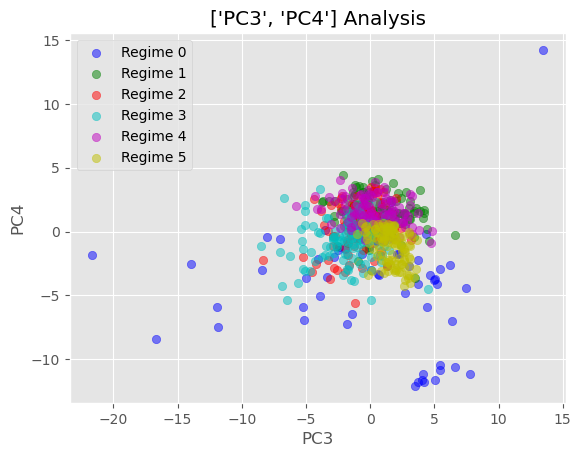

In [8]:
etfs = ['SPY', 'XLB', 'XLE', 'XLF', 'XLI', 'XLK', 'XLP', 'XLU', 'XLV', 'XLY']
macro_vars = ['PC3', 'PC4']

plt.clf()
colors = ['b', 'g', 'r', 'c', 'm', 'y']
for i in range(6):
    plt.scatter(memory_data[macro_vars[0]][:-1][regimes['cluster_step697'] == i], memory_data[macro_vars[1]][:-1][regimes['cluster_step697'] == i], c=colors[i], label=f"Regime {i}", alpha=0.5)
plt.title(f"{macro_vars} Analysis")
plt.xlabel(macro_vars[0])
plt.ylabel(macro_vars[1])
plt.legend()
plt.show()

In [9]:
# etfs = ['SPY', 'XLB', 'XLE', 'XLF', 'XLI', 'XLK', 'XLP', 'XLU', 'XLV', 'XLY']
# macro_var = 'PC0'

# for etf in etfs:
#     plt.clf()
#     colors = ['b', 'g', 'r', 'c', 'm', 'y']
#     for i in range(6):
#         plt.scatter(memory_data[-275:][macro_var][regimes[-275:]['cluster_step697'] == i],
#                     returns[etf][regimes[-275:]['cluster_step697'] == i], c=colors[i], label=f"Regime {i}", alpha=0.5)
#     plt.title(f"{etf} / {macro_var} Analysis")
#     plt.xlabel(macro_var)
#     plt.ylabel(etf + " Returns")
#     plt.legend()
#     plt.show()

In [10]:
all_portfolio_returns = []
colors = ['r', 'b', 'g', 'y', 'm', 'c', 'k']
line_types = ['-', '--', '-.', ':']
styles = ['m', 'c']
style_map = {}
for method in portfolio_methods:
    print(method)
    cur_color = colors.pop(0)
    dirs = os.listdir(os.path.join(outputs_path, method))

    for i, dir in enumerate(dirs):
        cur_line_type = line_types[i % len(line_types)]
        styles.append(f"{cur_color}{cur_line_type}")
        style_map[method + dir.split('/')[-1][7:-4]] = f"{cur_color}{cur_line_type}"
        print(method, dir)

        try:
            results = load_pickle(os.path.join(outputs_path, method, dir))
        except:
            print(method, dir)
            continue

        # get forecasts
        forecasts = results['forecasts']
        forecasts.index = pd.to_datetime(forecasts.index)
        forecasts.index.name = "date"

        # check which dataframe haas the smallest number of rows and match dates
        if len(forecasts) < len(returns):
            returns = returns.loc[forecasts.index[0]:forecasts.index[-1]]
        else:
            forecasts = forecasts.loc[returns.index[0]:returns.index[-1]]

        # intersect column names
        common_cols = forecasts.columns.intersection(returns.columns)

        # match columns
        forecasts = forecasts[common_cols].copy()
        returns = returns[common_cols].copy()

        # portfolio returns
        portfolio_returns = forecasts.multiply(returns, axis=0)

        model_tag = dir.split('.')[0][8:]
        #long_only_tag = dir.split('.')[0].split('_')[1]
        #num_assets_tag = dir.split('.')[0].split('_')[2]
        portfolio_returns["models"] = f"{method}_{model_tag}"

        all_portfolio_returns.append(portfolio_returns.reset_index().melt(["models", "date"]))
all_portfolio_returns_df = pd.concat(all_portfolio_returns)

naive
naive results_lo_4_rand.pkl
naive results_los_4.pkl
naive results_los_2.pkl
naive results_los_2_rand.pkl
naive results_los_3.pkl
naive results_lns_4.pkl
naive results_lns_2.pkl
naive results_los_4_rand.pkl
naive results_lns_3_rand.pkl
naive results_lns_4_rand.pkl
naive results_los_3_rand.pkl
naive results_lns_2_rand.pkl
naive results_mx_3.pkl
naive results_mx_4.pkl
naive results_mx_4_rand.pkl
naive results_lo_2.pkl
naive results_mx_3_rand.pkl
naive results_mx_2_rand.pkl
naive results_lo_2_rand.pkl
naive results_mx_2.pkl
naive results_lo_3.pkl
naive results_lo_4.pkl
naive results_lo_3_rand.pkl
naive results_lns_3.pkl
mvo
mvo results_lns_4.pkl
mvo results_lns_2.pkl
mvo results_lo_2.pkl
mvo results_lo_3.pkl
mvo results_lo_4.pkl
mvo results_lns_3.pkl
bl
bl results_lo_4_rand.pkl
bl results_lns_4.pkl
bl results_lns_2.pkl
bl results_lns_3_rand.pkl
bl results_lns_4_rand.pkl
bl results_lns_2_rand.pkl
bl results_lo_2.pkl
bl results_lo_2_rand.pkl
bl results_lo_3.pkl
bl results_lo_4.pkl
bl r

In [11]:
%config InlineBackend.figure_format = 'retina'
equal_weight_cumm_returns = pd.DataFrame(returns.mean(axis=1), columns=["ew"])
# spy_cumm_returns = pd.DataFrame(pd.DataFrame(returns['SPY'], columns=["SPY"]).sum(axis=1), columns=["spy"])
# concat_list = [equal_weight_cumm_returns, spy_cumm_returns]
concat_list = [equal_weight_cumm_returns]

model_list = all_portfolio_returns_df["models"].unique()
model_list = [
    'naive_lns_2',
    'naive_mx_2',
    'naive_los_2',
    'naive_lo_2',
    'naive_lns_3',
    'naive_mx_3',
    'naive_los_3',
    'naive_lo_3',
    'naive_mx_4',
    'naive_lns_4',
    'naive_los_4',
    'naive_lo_4',

    'naive_lns_2_rand',
    'naive_mx_2_rand',
    'naive_los_2_rand',
    'naive_lo_2_rand',
    'naive_lns_3_rand',
    'naive_mx_3_rand',
    'naive_los_3_rand',
    'naive_lo_3_rand',
    'naive_lns_4_rand',
    'naive_mx_4_rand',
    'naive_los_4_rand',
    'naive_lo_4_rand',

    'mvo_lns_2',
    'mvo_lo_2',
    'mvo_lns_3',
    'mvo_lo_3',
    'mvo_lns_4',
    'mvo_lo_4',

    'bl_lns_2',
    'bl_lo_2',
    'bl_lns_3',
    'bl_lo_3',
    'bl_lns_4',
    'bl_lo_4',

    'bl_lns_2_rand',
    'bl_lo_2_rand',
    'bl_lns_3_rand',
    'bl_lo_3_rand',
    'bl_lns_4_rand',
    'bl_lo_4_rand',

    'linear-ridge_lns_2',
    'linear-ridge_mx_2',
    'linear-ridge_los_2',
    'linear-ridge_lo_2',
    'linear-ridge_lns_3',
    'linear-ridge_mx_3',
    'linear-ridge_los_3',
    'linear-ridge_lo_3',
    'linear-ridge_lns_4',
    'linear-ridge_mx_4',
    'linear-ridge_los_4',
    'linear-ridge_lo_4',

    'linear-ridge_lns_2_rand',
    'linear-ridge_mx_2_rand',
    'linear-ridge_los_2_rand',
    'linear-ridge_lo_2_rand',
    'linear-ridge_lns_3_rand',
    'linear-ridge_mx_3_rand',
    'linear-ridge_los_3_rand',
    'linear-ridge_lo_3_rand',
    'linear-ridge_lns_4_rand',
    'linear-ridge_mx_4_rand',
    'linear-ridge_los_4_rand',
    'linear-ridge_lo_4_rand',
]
print(style_map)
styles = ['m', 'c'] + [style_map[model] for model in model_list]
for model in model_list:
    tmp_portfolio_returns = all_portfolio_returns_df[all_portfolio_returns_df["models"] == model]
    tmp_portfolio_returns = tmp_portfolio_returns.drop("models", axis=1).pivot_table(index="date", columns="variable", values="value")
    order = tmp_portfolio_returns.cumsum().mean(axis=0).sort_values(ascending=False).index
    # ax = tmp_portfolio_returns.cumsum()[order].plot(figsize=(10, 6), title=f"Individual Asset Cumulative Returns: Model = {model}")
    
    # # Place the legend outside the plot
    # ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # plt.show()

    # add equal weight
    concat_list.append(pd.DataFrame(tmp_portfolio_returns.sum(axis=1), columns=[model]))

{'naive_lo_4_rand': 'r-', 'naive_los_4': 'r--', 'naive_los_2': 'r-.', 'naive_los_2_rand': 'r:', 'naive_los_3': 'r-', 'naive_lns_4': 'r--', 'naive_lns_2': 'r-.', 'naive_los_4_rand': 'r:', 'naive_lns_3_rand': 'r-', 'naive_lns_4_rand': 'r--', 'naive_los_3_rand': 'r-.', 'naive_lns_2_rand': 'r:', 'naive_mx_3': 'r-', 'naive_mx_4': 'r--', 'naive_mx_4_rand': 'r-.', 'naive_lo_2': 'r:', 'naive_mx_3_rand': 'r-', 'naive_mx_2_rand': 'r--', 'naive_lo_2_rand': 'r-.', 'naive_mx_2': 'r:', 'naive_lo_3': 'r-', 'naive_lo_4': 'r--', 'naive_lo_3_rand': 'r-.', 'naive_lns_3': 'r:', 'mvo_lns_4': 'b-', 'mvo_lns_2': 'b--', 'mvo_lo_2': 'b-.', 'mvo_lo_3': 'b:', 'mvo_lo_4': 'b-', 'mvo_lns_3': 'b--', 'bl_lo_4_rand': 'g-', 'bl_lns_4': 'g--', 'bl_lns_2': 'g-.', 'bl_lns_3_rand': 'g:', 'bl_lns_4_rand': 'g-', 'bl_lns_2_rand': 'g--', 'bl_lo_2': 'g-.', 'bl_lo_2_rand': 'g:', 'bl_lo_3': 'g-', 'bl_lo_4': 'g--', 'bl_lo_3_rand': 'g-.', 'bl_lns_3': 'g:', 'linear-ridge_lo_4_rand': 'y-', 'linear-ridge_los_4': 'y--', 'linear-ridge_

In [12]:
# ew_vol_scale = 10 / (equal_weight_cumm_returns.rolling(window=3).std() * 12 * 100)
# tensor_scaled_equal_weight_cumm_returns = torch.tensor((equal_weight_cumm_returns * ew_vol_scale).dropna().values)
ew_summary_statistics = compute_summary_statistics(torch.tensor(equal_weight_cumm_returns.values))
ew_summary_statistics = pd.DataFrame([ew_summary_statistics], index=["EW"])

all_summary_statistics = []
for model in all_portfolio_returns_df["models"].unique():
    tmp_portfolio_returns = all_portfolio_returns_df[all_portfolio_returns_df["models"] == model]
    tmp_portfolio_returns = tmp_portfolio_returns.drop("models", axis=1).pivot_table(index="date", columns="variable", values="value")

    vol_scale = 10 / (tmp_portfolio_returns.mean(axis=1).rolling(window=3).std() * 12 * 100)
    tensor_tmp_portfolio_returns = torch.tensor((tmp_portfolio_returns.mean(axis=1) * vol_scale).dropna().values)
    summary_statistics = compute_summary_statistics(tensor_tmp_portfolio_returns)
    summary_statistics = pd.DataFrame([summary_statistics], index=[model])

    all_summary_statistics.append(summary_statistics)
all_summary_statistics_df = pd.concat(all_summary_statistics)

In [13]:
ew_summary_statistics

E[R]     Std(R)    Sharpe   Sortino     AvgDD      MaxDD  \
EW  5.355167  48.903031  0.379339  0.552381 -7.785975 -34.236618   

    % Positive Ret.  
EW         0.577465

In [14]:
print(ew_summary_statistics.round(3).to_latex())

\begin{tabular}{lrrrrrrr}
\toprule
 & E[R] & Std(R) & Sharpe & Sortino & AvgDD & MaxDD & % Positive Ret. \\
\midrule
EW & 5.355000 & 48.903000 & 0.379000 & 0.552000 & -7.786000 & -34.237000 & 0.577000 \\
\bottomrule
\end{tabular}



In [15]:
all_summary_statistics_df

E[R]     Std(R)    Sharpe   Sortino      AvgDD  \
naive_lo_4_rand         1.608647  16.291144  0.342058  0.666263  -5.210821   
naive_los_4             3.094686  16.912618  0.633864  1.526274  -1.783892   
naive_los_2             2.078233  13.635940  0.527959  1.015581  -2.609023   
naive_los_2_rand        0.432381  15.378286  0.097398  0.102505  -2.560459   
naive_los_3             3.005453  13.348209  0.779969  1.734012  -1.331664   
...                          ...        ...       ...       ...        ...   
linear-ridge_mx_2       3.627577  11.945880  1.051935  1.506825  -1.198823   
linear-ridge_lo_3       2.744435  11.660417  0.815323  1.320953  -1.319761   
linear-ridge_lo_4       3.886518  21.143547  0.636757  1.789880  -1.207771   
linear-ridge_lo_3_rand -1.225977  34.119644 -0.124471 -0.088390 -28.217158   
linear-ridge_lns_3      5.352987  14.402872  1.287472  2.571422  -0.954673   

                            MaxDD  % Positive Ret.  
naive_lo_4_rand        -14.719647         0.535545  
naive_los_4             -8.086890         0.535545  
naive_los_2             -8.500935         0.545024  
naive_los_2_rand       -24.915488         0.516588  
naive_los_3             -4.417987         0.573460  
...                           ...              ...  
linear-ridge_mx_2      -11.528044         0.625592  
linear-ridge_lo_3       -6.448127         0.559242  
linear-ridge_lo_4       -6.645168         0.563981  
linear-ridge_lo_3_rand -39.370997         0.514286  
linear-ridge_lns_3      -6.519758         0.644550  

[66 rows x 7 columns]

In [16]:
all_summary_statistics_df

E[R]     Std(R)    Sharpe   Sortino      AvgDD  \
naive_lo_4_rand         1.608647  16.291144  0.342058  0.666263  -5.210821   
naive_los_4             3.094686  16.912618  0.633864  1.526274  -1.783892   
naive_los_2             2.078233  13.635940  0.527959  1.015581  -2.609023   
naive_los_2_rand        0.432381  15.378286  0.097398  0.102505  -2.560459   
naive_los_3             3.005453  13.348209  0.779969  1.734012  -1.331664   
...                          ...        ...       ...       ...        ...   
linear-ridge_mx_2       3.627577  11.945880  1.051935  1.506825  -1.198823   
linear-ridge_lo_3       2.744435  11.660417  0.815323  1.320953  -1.319761   
linear-ridge_lo_4       3.886518  21.143547  0.636757  1.789880  -1.207771   
linear-ridge_lo_3_rand -1.225977  34.119644 -0.124471 -0.088390 -28.217158   
linear-ridge_lns_3      5.352987  14.402872  1.287472  2.571422  -0.954673   

                            MaxDD  % Positive Ret.  
naive_lo_4_rand        -14.719647         0.535545  
naive_los_4             -8.086890         0.535545  
naive_los_2             -8.500935         0.545024  
naive_los_2_rand       -24.915488         0.516588  
naive_los_3             -4.417987         0.573460  
...                           ...              ...  
linear-ridge_mx_2      -11.528044         0.625592  
linear-ridge_lo_3       -6.448127         0.559242  
linear-ridge_lo_4       -6.645168         0.563981  
linear-ridge_lo_3_rand -39.370997         0.514286  
linear-ridge_lns_3      -6.519758         0.644550  

[66 rows x 7 columns]

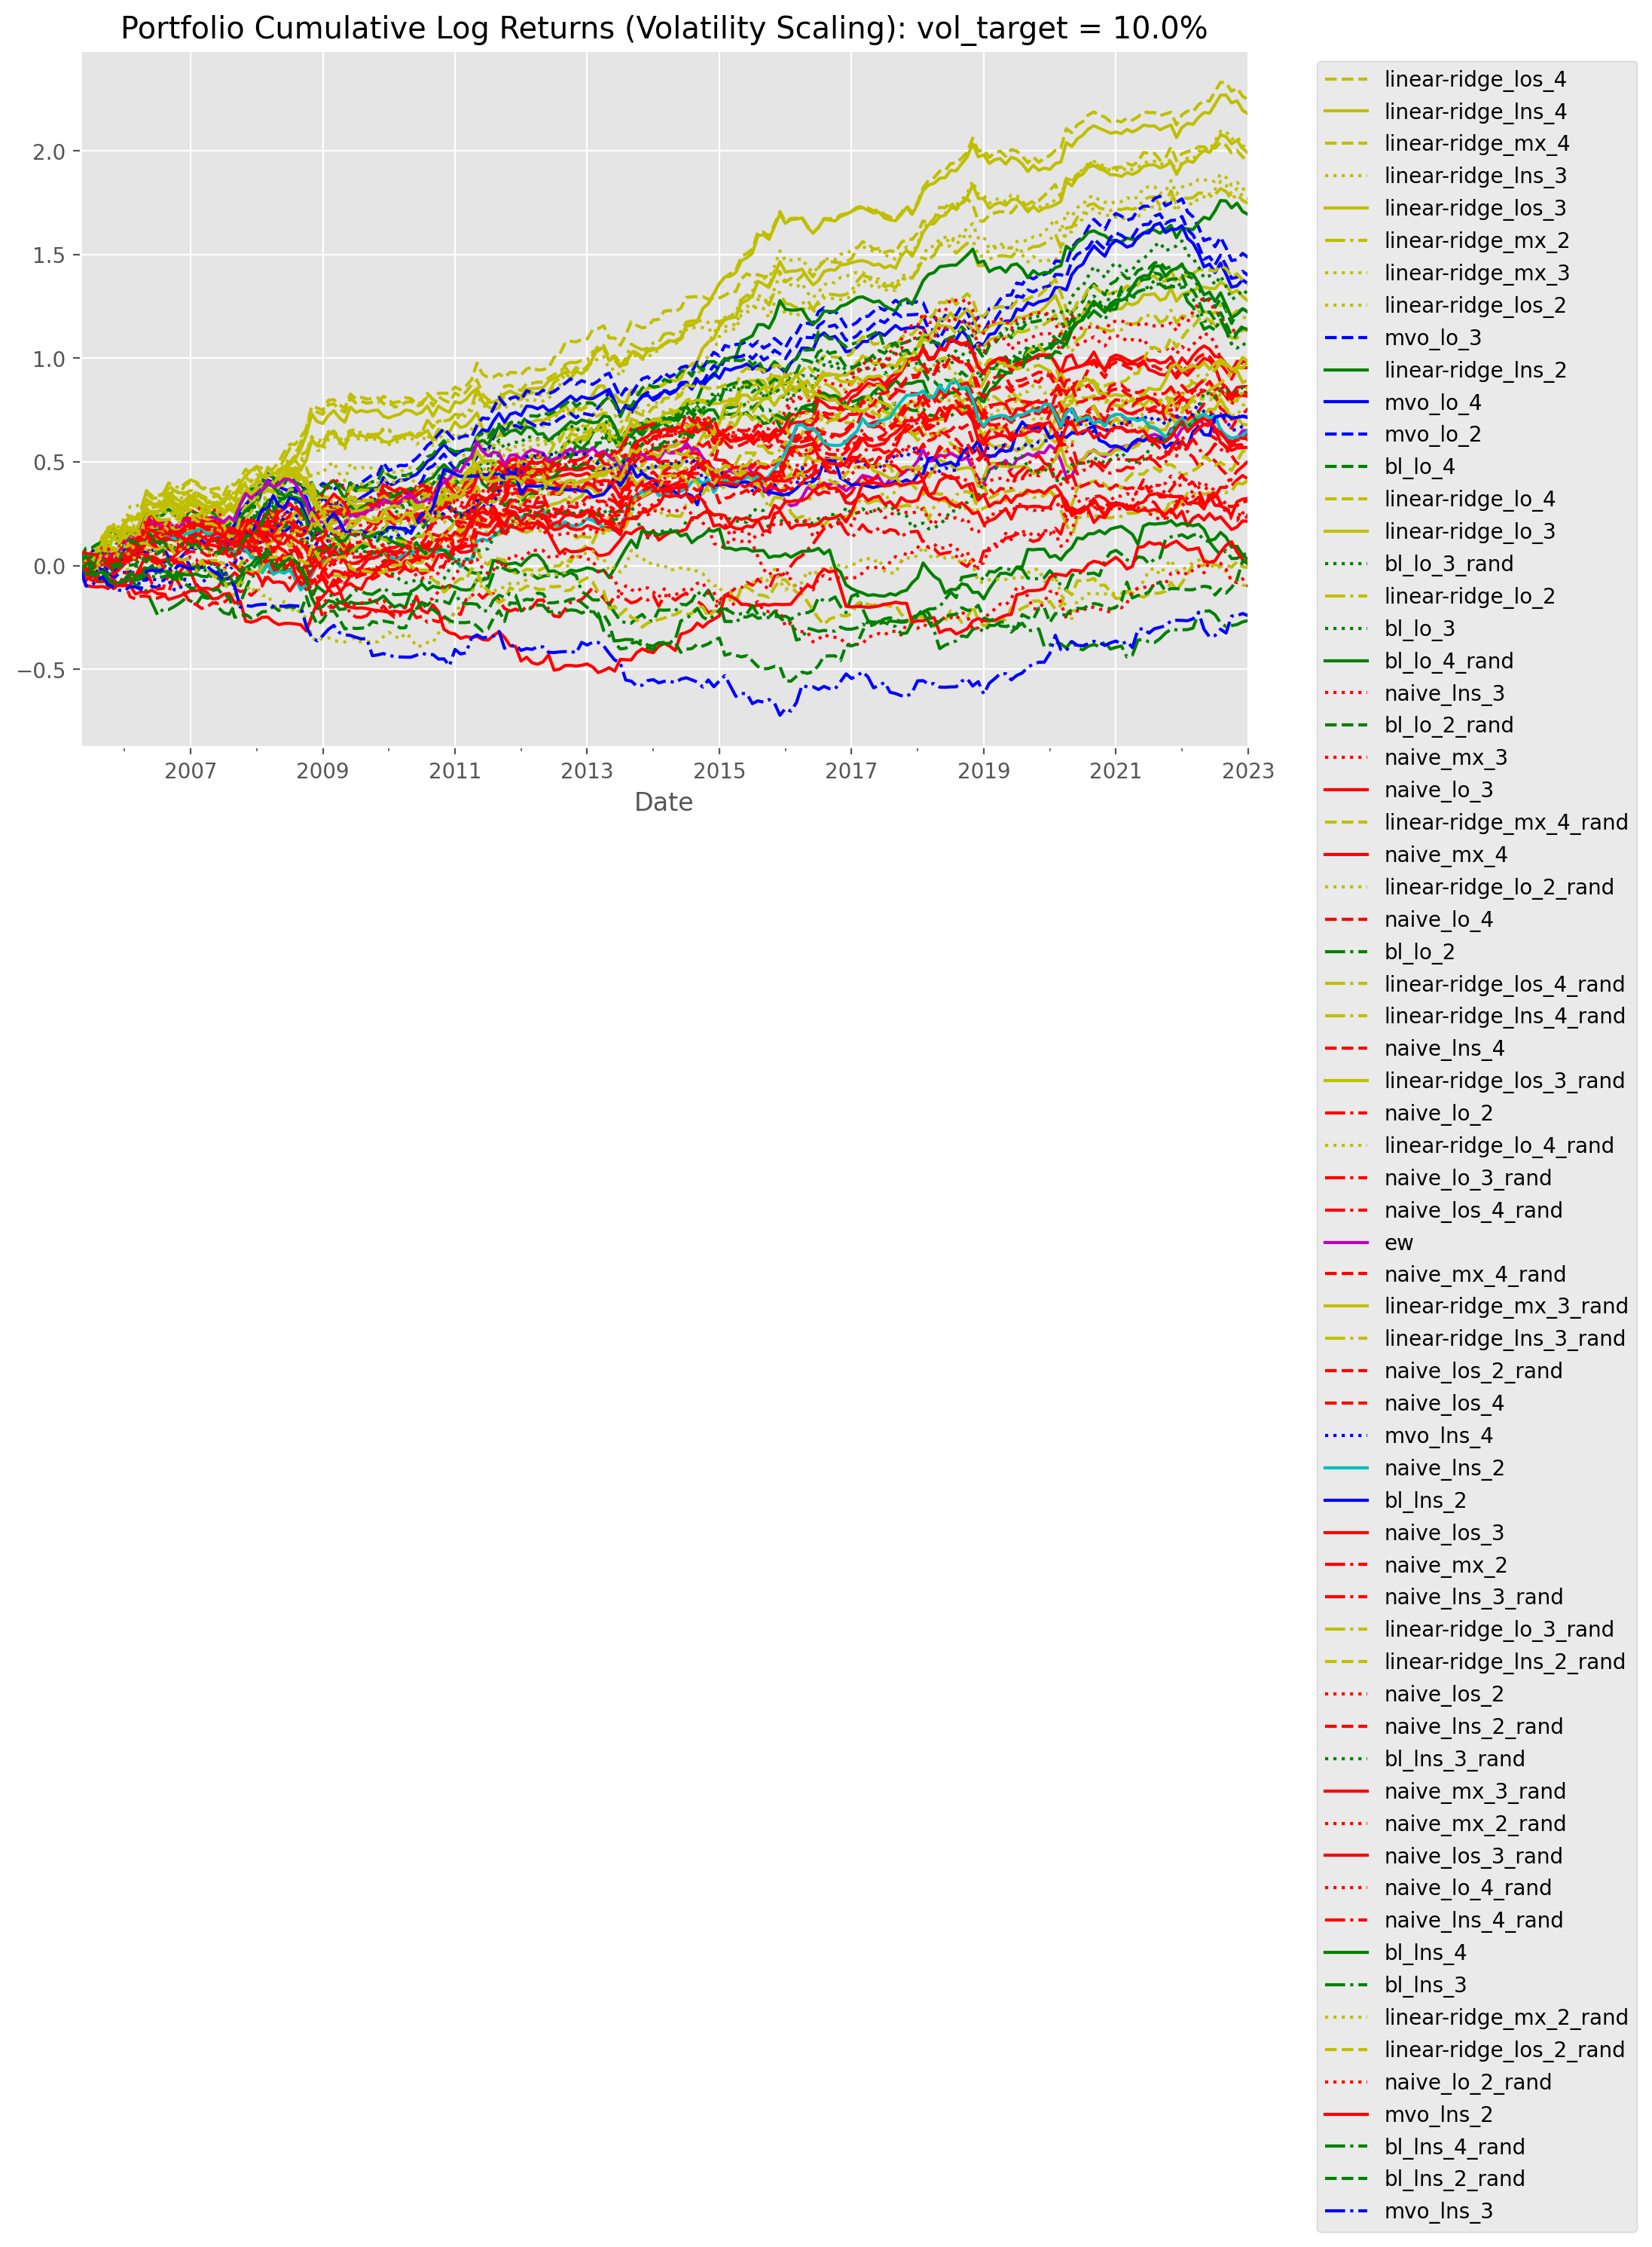

In [17]:
returns = pd.concat(concat_list, axis=1)
cum_returns_plot = returns.cumsum()

# Volatility scaling
vol_target = 0.10
portfolio_vol = vol_target / (returns.rolling(window=12).std().bfill() * np.sqrt(12))
voladj_returns = (returns * portfolio_vol).dropna()
cum_voladj_returns = voladj_returns.cumsum()
order = cum_voladj_returns.mean(axis=0).sort_values(ascending=False).index
order_style = list(cum_voladj_returns.mean(axis=0).argsort())
ax = cum_voladj_returns[order].plot(figsize=(10, 6), style=[styles[x] for x in reversed(order_style)], title=f"Portfolio Cumulative Log Returns (Volatility Scaling): vol_target = {vol_target * 100}%", xlabel="Date")

# Place the legend outside the plot
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

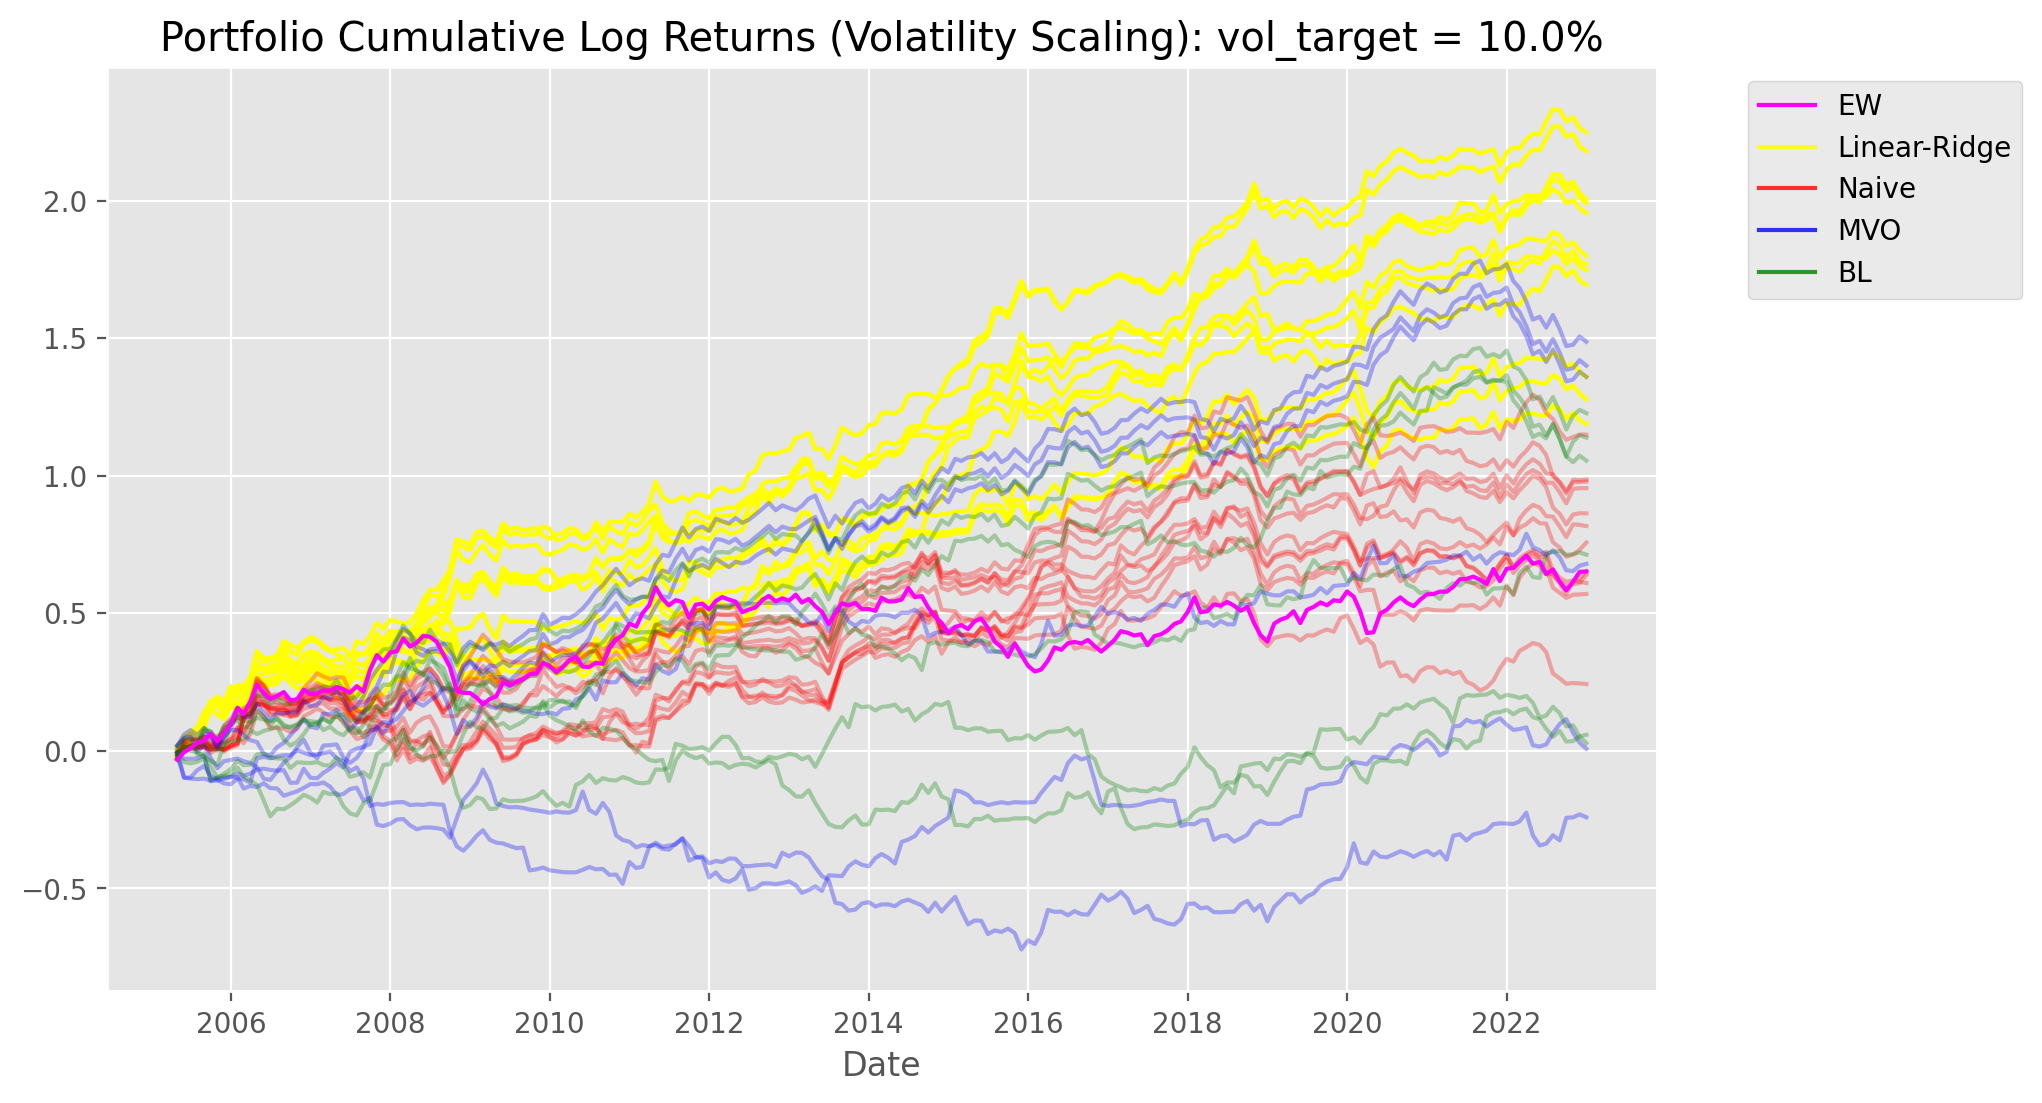

In [18]:
# Group models
linear_ridge_models = [m for m in returns.columns if (m.startswith('linear-ridge')) and (not m.endswith('rand'))]
naive_models = [m for m in returns.columns if (m.startswith('naive')) and (not m.endswith('rand'))]
mvo_models = [m for m in returns.columns if (m.startswith('mvo')) and (not m.endswith('rand'))]
bl_models = [m for m in returns.columns if (m.startswith('bl')) and (not m.endswith('rand'))]

fig, ax = plt.subplots(figsize=(10, 6))

# Plot each group
for model in linear_ridge_models:
   plt.plot(cum_voladj_returns.index, cum_voladj_returns[model], color='yellow', alpha=1)
for model in naive_models:
   plt.plot(cum_voladj_returns.index, cum_voladj_returns[model], color='red', alpha=0.3)
for model in mvo_models:
   plt.plot(cum_voladj_returns.index, cum_voladj_returns[model], color='blue', alpha=0.3)
for model in bl_models:
   plt.plot(cum_voladj_returns.index, cum_voladj_returns[model], color='green', alpha=0.3)

# Plot benchmarks
plt.plot(cum_voladj_returns.index, cum_voladj_returns['ew'], color='magenta', label='EW')
# plt.plot(cum_voladj_returns.index, cum_voladj_returns['spy'], color='cyan', label='SPY')

# Add representative lines for legend
plt.plot([], [], color='yellow', label='Linear-Ridge', alpha=0.8)
plt.plot([], [], color='red', label='Naive', alpha=0.8)
plt.plot([], [], color='blue', label='MVO', alpha=0.8)
plt.plot([], [], color='green', label='BL', alpha=0.8)

plt.title(f"Portfolio Cumulative Log Returns (Volatility Scaling): vol_target = {vol_target * 100}%")
plt.xlabel("Date")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)

# save image
plt.savefig(os.path.join(outputs_path, "results", "futures_all_cum_ret_by_groups.png"), bbox_inches='tight', dpi=300)

plt.show()

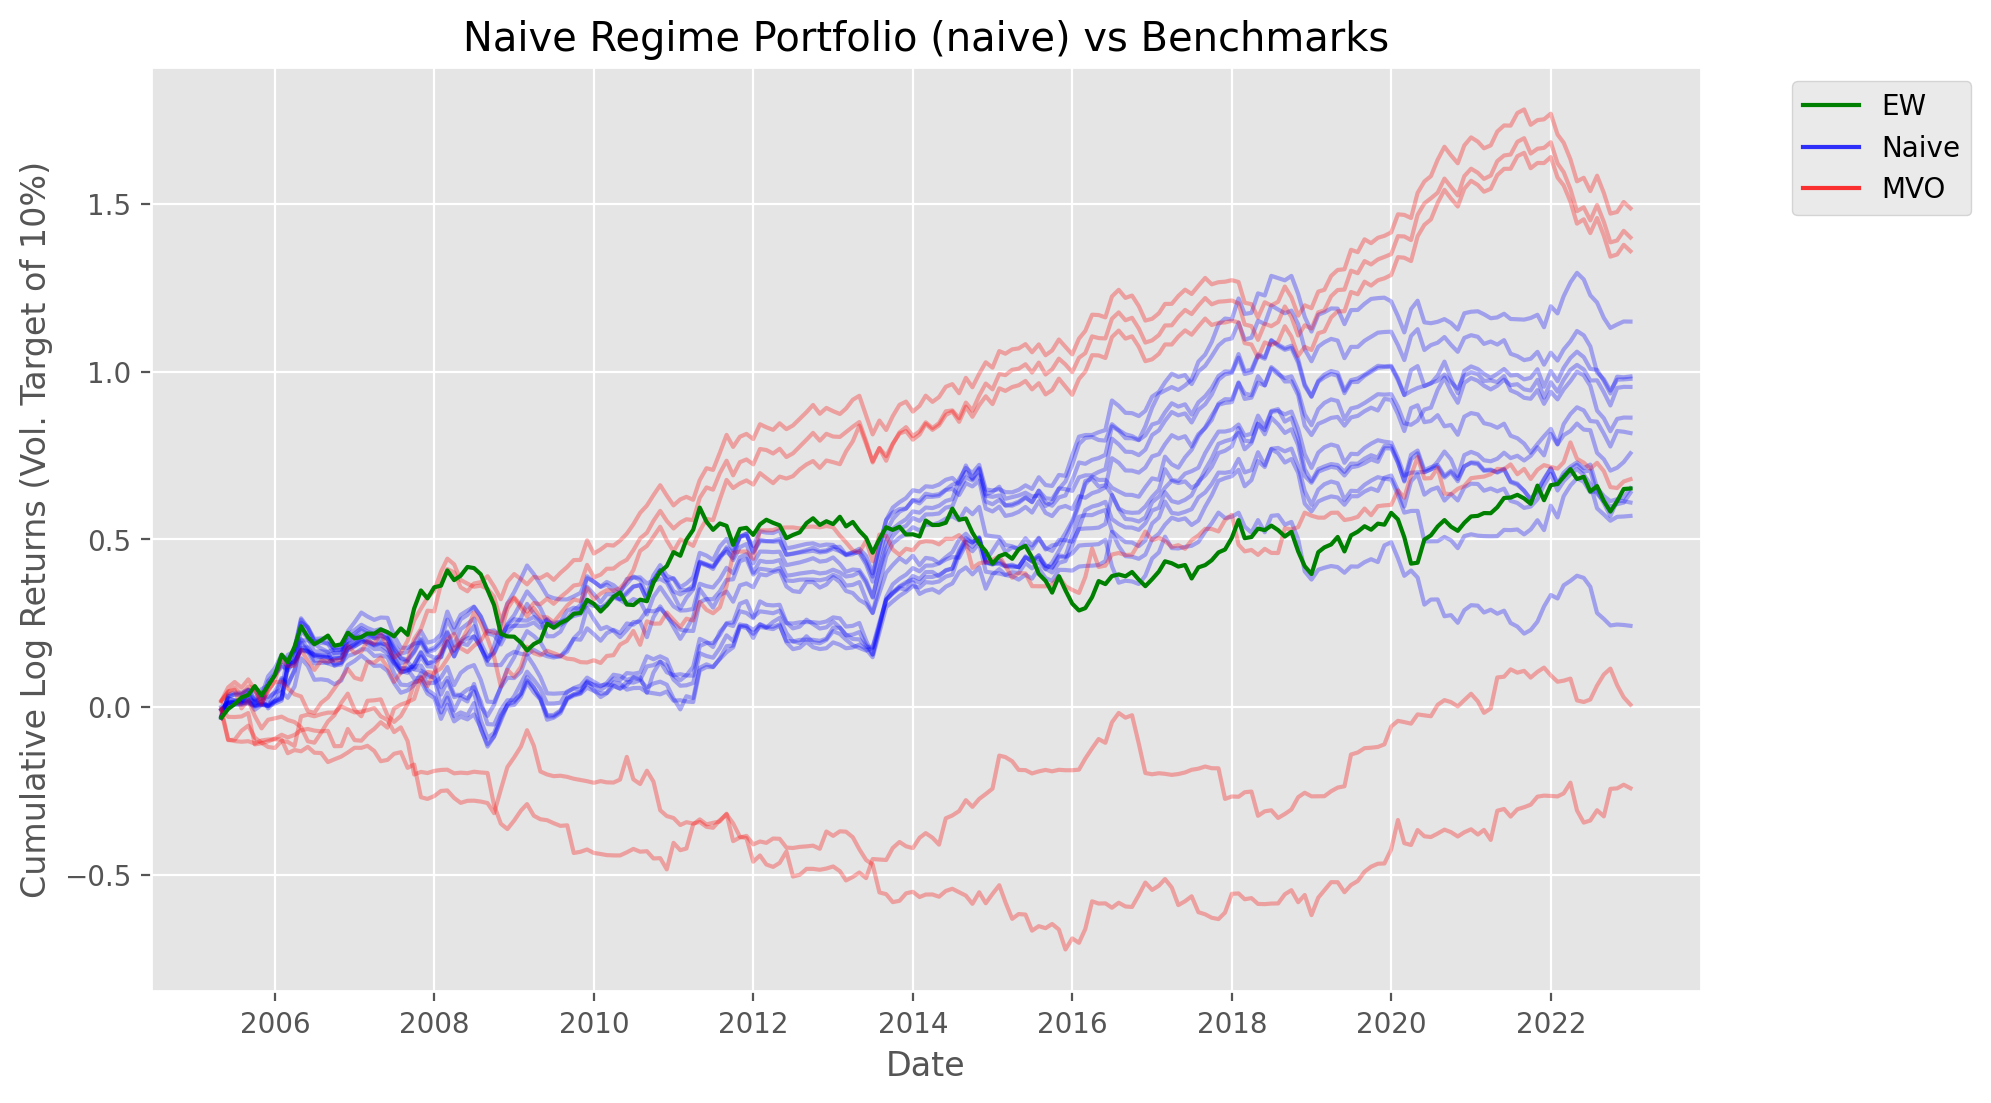

In [19]:
super_benchmarks = ['ew']
selected_model_list = [
    'naive_lns_2',
    'naive_mx_2',
    'naive_los_2',
    'naive_lo_2',
    'naive_lns_3',
    'naive_mx_3',
    'naive_los_3',
    'naive_lo_3',
    'naive_mx_4',
    'naive_lns_4',
    'naive_los_4',
    'naive_lo_4',

    'mvo_lns_2',
    'mvo_lo_2',
    'mvo_lns_3',
    'mvo_lo_3',
    'mvo_lns_4',
    'mvo_lo_4',
]

returns = pd.concat(concat_list, axis=1).copy()[selected_model_list + super_benchmarks]
cum_returns_plot = returns.cumsum()

# Volatility scaling
vol_target = 0.10
portfolio_vol = vol_target / (returns.rolling(window=12).std().bfill() * np.sqrt(12))
voladj_returns = (returns * portfolio_vol).dropna()
cum_voladj_returns = voladj_returns.cumsum()
order = cum_voladj_returns.mean(axis=0).sort_values(ascending=False).index

# Group models 
naive_models = [m for m in selected_model_list if m.startswith('naive')]
mvo_models = [m for m in selected_model_list if m.startswith('mvo')]

fig, ax = plt.subplots(figsize=(10, 6))

# Plot naive models in blue
for model in naive_models:
   plt.plot(cum_voladj_returns.index, cum_voladj_returns[model], color='blue', alpha=0.3)

# Plot mvo models in red  
for model in mvo_models:
   plt.plot(cum_voladj_returns.index, cum_voladj_returns[model], color='red', alpha=0.3)

# Plot benchmarks
plt.plot(cum_voladj_returns.index, cum_voladj_returns['ew'], color='green', label='EW')
# plt.plot(cum_voladj_returns.index, cum_voladj_returns['spy'], color='black', label='SPY')

# Add representative lines for legend
plt.plot([], [], color='blue', label='Naive', alpha=0.8)
plt.plot([], [], color='red', label='MVO', alpha=0.8)

plt.title(f"Naive Regime Portfolio (naive) vs Benchmarks")
plt.ylabel("Cumulative Log Returns (Vol. Target of 10%)")
plt.xlabel("Date")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)

# save image
plt.savefig(os.path.join(outputs_path, "results", "futures_naive_vs_benchmarks_cumret.png"), bbox_inches='tight', dpi=300)

plt.show()

In [20]:
selected_summary_statistics = []
for model in cum_voladj_returns.columns:
    if model not in super_benchmarks:
        summary_statistics = pd.DataFrame([all_summary_statistics_df.loc[model]], index=[model])
        selected_summary_statistics.append(summary_statistics)
selected_summary_statistics_df = pd.concat(selected_summary_statistics)

selected_summary_statistics_df.round(3)

E[R]  Std(R)  Sharpe  Sortino  AvgDD   MaxDD  % Positive Ret.
naive_lns_2  3.651  21.204   0.596    1.852 -1.945  -8.496            0.564
naive_mx_2   2.177  14.399   0.524    0.871 -2.257  -9.476            0.555
naive_los_2  2.078  13.636   0.528    1.016 -2.609  -8.501            0.545
naive_lo_2   2.641  13.799   0.663    1.358 -1.626  -6.697            0.545
naive_lns_3  3.106  16.115   0.668    1.241 -2.433  -9.075            0.573
naive_mx_3   3.646  13.242   0.954    2.067 -1.057  -4.939            0.611
naive_los_3  3.005  13.348   0.780    1.734 -1.332  -4.418            0.573
naive_lo_3   2.872  12.531   0.794    1.460 -1.260  -6.025            0.592
naive_mx_4   4.496  17.714   0.879    2.462 -1.186  -5.101            0.583
naive_lns_4  2.662  17.298   0.533    0.866 -3.041 -14.378            0.531
naive_los_4  3.095  16.913   0.634    1.526 -1.784  -8.087            0.536
naive_lo_4   3.417  15.499   0.764    1.755 -1.309  -6.181            0.588
mvo_lns_2    0.924  13.877   0.231    0.304 -7.055 -19.428            0.536
mvo_lo_2     3.870  12.865   1.042    2.132 -1.069  -7.844            0.616
mvo_lns_3    0.391  11.448   0.118    0.199 -8.473 -17.689            0.521
mvo_lo_3     5.874  18.653   1.091    3.558 -0.978  -7.721            0.607
mvo_lns_4    2.090  17.326   0.418    0.444 -7.412 -17.344            0.555
mvo_lo_4     5.540  17.569   1.092    3.383 -1.079  -7.633            0.611

In [21]:
print(selected_summary_statistics_df.drop(['E[R]', 'Std(R)', 'AvgDD'], axis=1).round(3).to_latex())

\begin{tabular}{lrrrr}
\toprule
 & Sharpe & Sortino & MaxDD & % Positive Ret. \\
\midrule
naive_lns_2 & 0.596000 & 1.852000 & -8.496000 & 0.564000 \\
naive_mx_2 & 0.524000 & 0.871000 & -9.476000 & 0.555000 \\
naive_los_2 & 0.528000 & 1.016000 & -8.501000 & 0.545000 \\
naive_lo_2 & 0.663000 & 1.358000 & -6.697000 & 0.545000 \\
naive_lns_3 & 0.668000 & 1.241000 & -9.075000 & 0.573000 \\
naive_mx_3 & 0.954000 & 2.067000 & -4.939000 & 0.611000 \\
naive_los_3 & 0.780000 & 1.734000 & -4.418000 & 0.573000 \\
naive_lo_3 & 0.794000 & 1.460000 & -6.025000 & 0.592000 \\
naive_mx_4 & 0.879000 & 2.462000 & -5.101000 & 0.583000 \\
naive_lns_4 & 0.533000 & 0.866000 & -14.378000 & 0.531000 \\
naive_los_4 & 0.634000 & 1.526000 & -8.087000 & 0.536000 \\
naive_lo_4 & 0.764000 & 1.755000 & -6.181000 & 0.588000 \\
mvo_lns_2 & 0.231000 & 0.304000 & -19.428000 & 0.536000 \\
mvo_lo_2 & 1.042000 & 2.132000 & -7.844000 & 0.616000 \\
mvo_lns_3 & 0.118000 & 0.199000 & -17.689000 & 0.521000 \\
mvo_lo_3 & 1.091000 

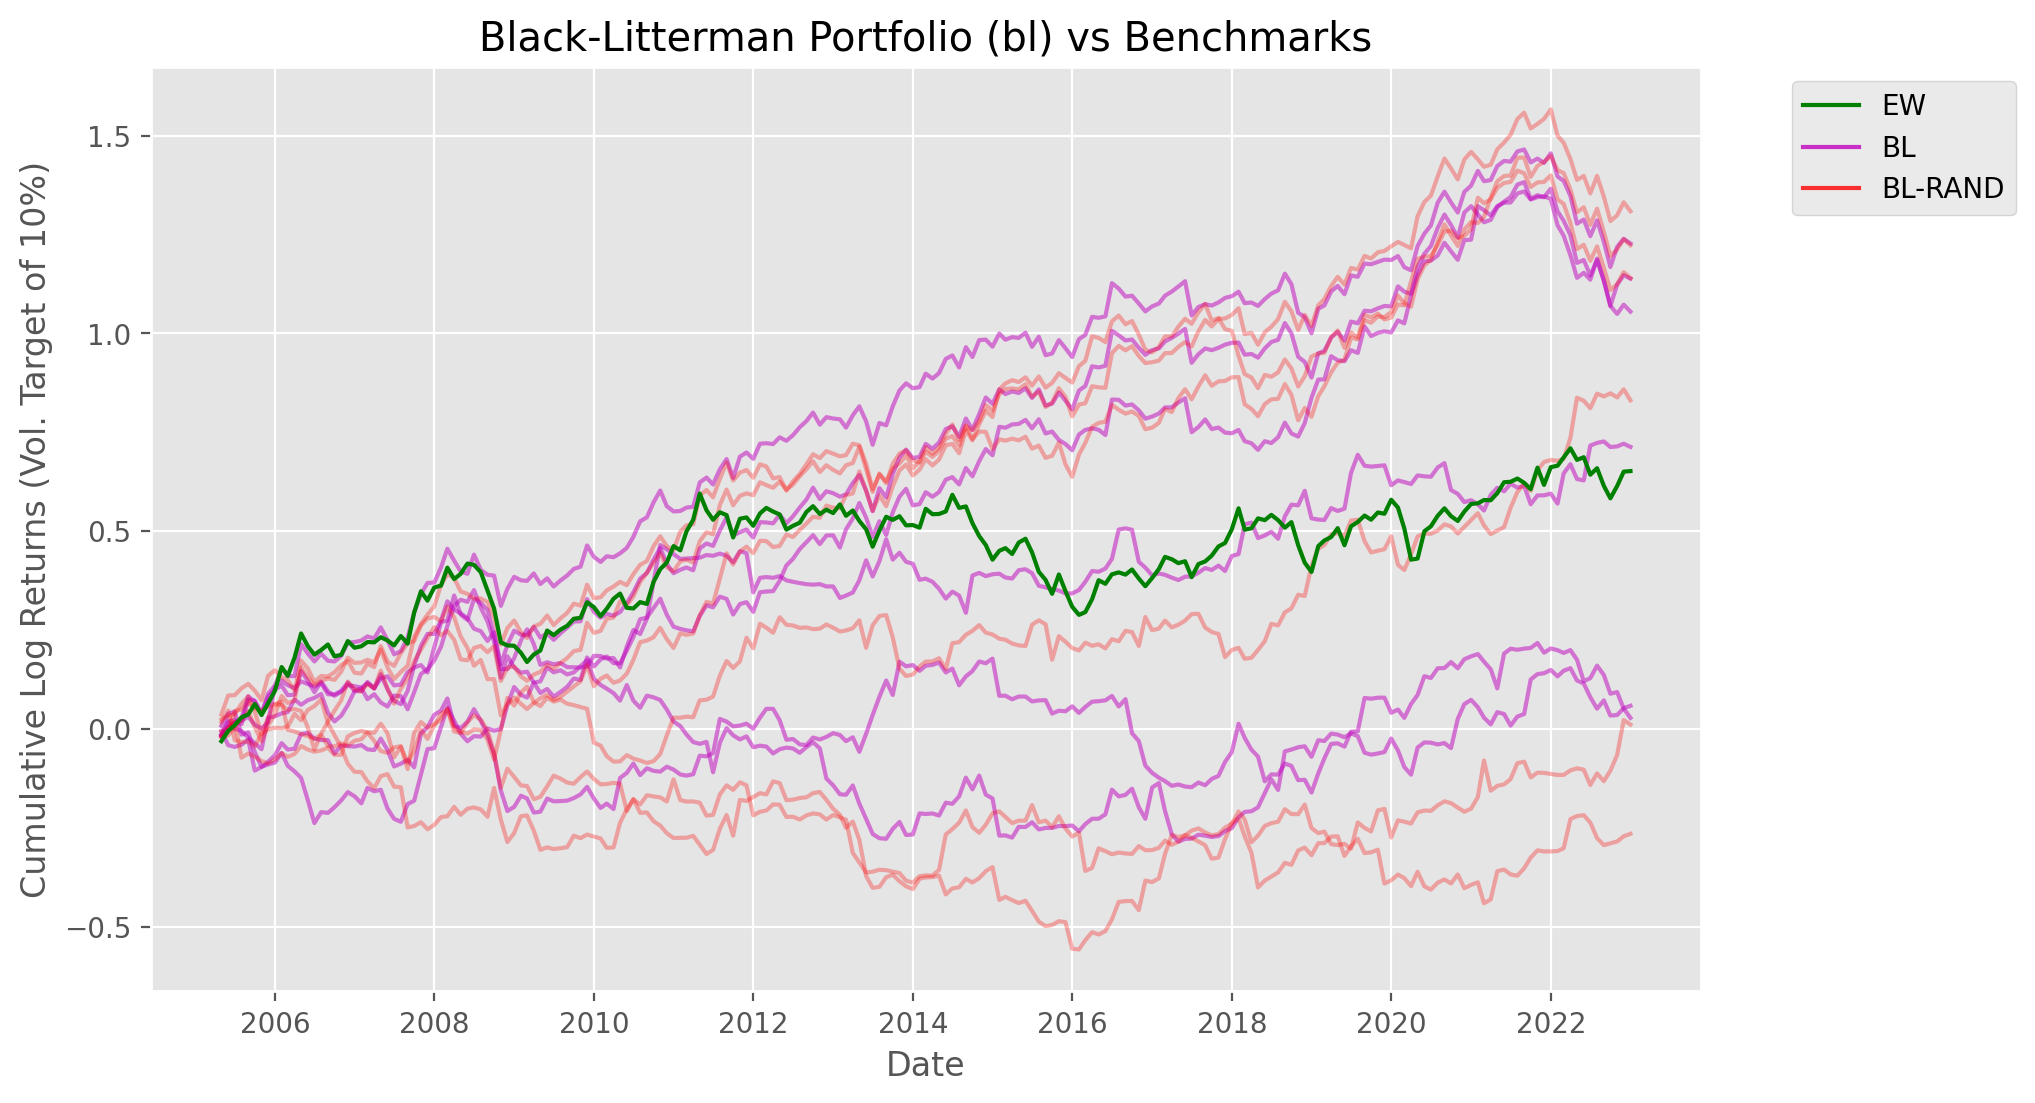

In [22]:
super_benchmarks = ['ew']
selected_model_list = [
    'bl_lns_2',
    'bl_lo_2',
    'bl_lns_3',
    'bl_lo_3',
    'bl_lns_4',
    'bl_lo_4',
   #  'bl_lns_5',
   #  'bl_lo_5',

    'bl_lns_2_rand',
    'bl_lo_2_rand',
    'bl_lns_3_rand',
    'bl_lo_3_rand',
    'bl_lns_4_rand',
    'bl_lo_4_rand',
   #  'bl_lns_5_rand',
   #  'bl_lo_5_rand',
]

returns = pd.concat(concat_list, axis=1).copy()[selected_model_list + super_benchmarks]
cum_returns_plot = returns.cumsum()

# Volatility scaling
vol_target = 0.10
portfolio_vol = vol_target / (returns.rolling(window=12).std().bfill() * np.sqrt(12))
voladj_returns = (returns * portfolio_vol).dropna()
cum_voladj_returns = voladj_returns.cumsum()
order = cum_voladj_returns.mean(axis=0).sort_values(ascending=False).index

# Group models 
naive_models = [m for m in selected_model_list if (m.startswith('bl')) and (not m.endswith('rand'))]
mvo_models = [m for m in selected_model_list if (m.endswith('rand'))]

fig, ax = plt.subplots(figsize=(10, 6))

# Plot naive models in blue
for model in naive_models:
   plt.plot(cum_voladj_returns.index, cum_voladj_returns[model], color='m', alpha=0.5)

# Plot mvo models in red  
for model in mvo_models:
   plt.plot(cum_voladj_returns.index, cum_voladj_returns[model], color='red', alpha=0.3)

# Plot benchmarks
plt.plot(cum_voladj_returns.index, cum_voladj_returns['ew'], color='green', label='EW')
# plt.plot(cum_voladj_returns.index, cum_voladj_returns['spy'], color='black', label='SPY')

# Add representative lines for legend
plt.plot([], [], color='m', label='BL', alpha=0.8)
plt.plot([], [], color='red', label='BL-RAND', alpha=0.8)

plt.title(f"Black-Litterman Portfolio (bl) vs Benchmarks")
plt.ylabel("Cumulative Log Returns (Vol. Target of 10%)")
plt.xlabel("Date")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)

# save image
plt.savefig(os.path.join(outputs_path, "results", "futures_bl_vs_benchmarks_cumret.png"), bbox_inches='tight', dpi=300)

plt.show()

In [23]:
selected_summary_statistics = []
for model in cum_voladj_returns.columns:
    if model not in super_benchmarks:
        summary_statistics = pd.DataFrame([all_summary_statistics_df.loc[model]], index=[model])
        selected_summary_statistics.append(summary_statistics)
selected_summary_statistics_df = pd.concat(selected_summary_statistics)

selected_summary_statistics_df.round(3)

E[R]  Std(R)  Sharpe  Sortino   AvgDD   MaxDD  % Positive Ret.
bl_lns_2      -0.134  18.340  -0.025   -0.025  -9.559 -21.868            0.517
bl_lo_2        3.052  13.769   0.768    1.557  -1.638  -8.693            0.578
bl_lns_3      -0.163  14.894  -0.038   -0.047 -16.653 -30.982            0.512
bl_lo_3        5.243  19.935   0.911    3.082  -1.216  -8.209            0.578
bl_lns_4       2.886  24.062   0.415    1.216  -2.335 -10.510            0.540
bl_lo_4        5.227  14.970   1.210    3.492  -0.818  -6.286            0.607
bl_lns_2_rand  0.053  13.140   0.014    0.019 -11.849 -22.488            0.550
bl_lo_2_rand   3.039  11.946   0.881    1.571  -1.530  -9.360            0.602
bl_lns_3_rand  1.568  12.454   0.436    0.660  -4.537 -15.303            0.545
bl_lo_3_rand   7.378  26.802   0.954    4.976  -0.916  -7.022            0.626
bl_lns_4_rand  0.010  12.220   0.003    0.004  -7.514 -15.588            0.531
bl_lo_4_rand   4.581  14.427   1.100    2.950  -1.088  -6.804            0.621

In [24]:
print(selected_summary_statistics_df.drop(['E[R]', 'Std(R)', 'AvgDD'], axis=1).round(3).to_latex())

\begin{tabular}{lrrrr}
\toprule
 & Sharpe & Sortino & MaxDD & % Positive Ret. \\
\midrule
bl_lns_2 & -0.025000 & -0.025000 & -21.868000 & 0.517000 \\
bl_lo_2 & 0.768000 & 1.557000 & -8.693000 & 0.578000 \\
bl_lns_3 & -0.038000 & -0.047000 & -30.982000 & 0.512000 \\
bl_lo_3 & 0.911000 & 3.082000 & -8.209000 & 0.578000 \\
bl_lns_4 & 0.415000 & 1.216000 & -10.510000 & 0.540000 \\
bl_lo_4 & 1.210000 & 3.492000 & -6.286000 & 0.607000 \\
bl_lns_2_rand & 0.014000 & 0.019000 & -22.488000 & 0.550000 \\
bl_lo_2_rand & 0.881000 & 1.571000 & -9.360000 & 0.602000 \\
bl_lns_3_rand & 0.436000 & 0.660000 & -15.303000 & 0.545000 \\
bl_lo_3_rand & 0.954000 & 4.976000 & -7.022000 & 0.626000 \\
bl_lns_4_rand & 0.003000 & 0.004000 & -15.588000 & 0.531000 \\
bl_lo_4_rand & 1.100000 & 2.950000 & -6.804000 & 0.621000 \\
\bottomrule
\end{tabular}



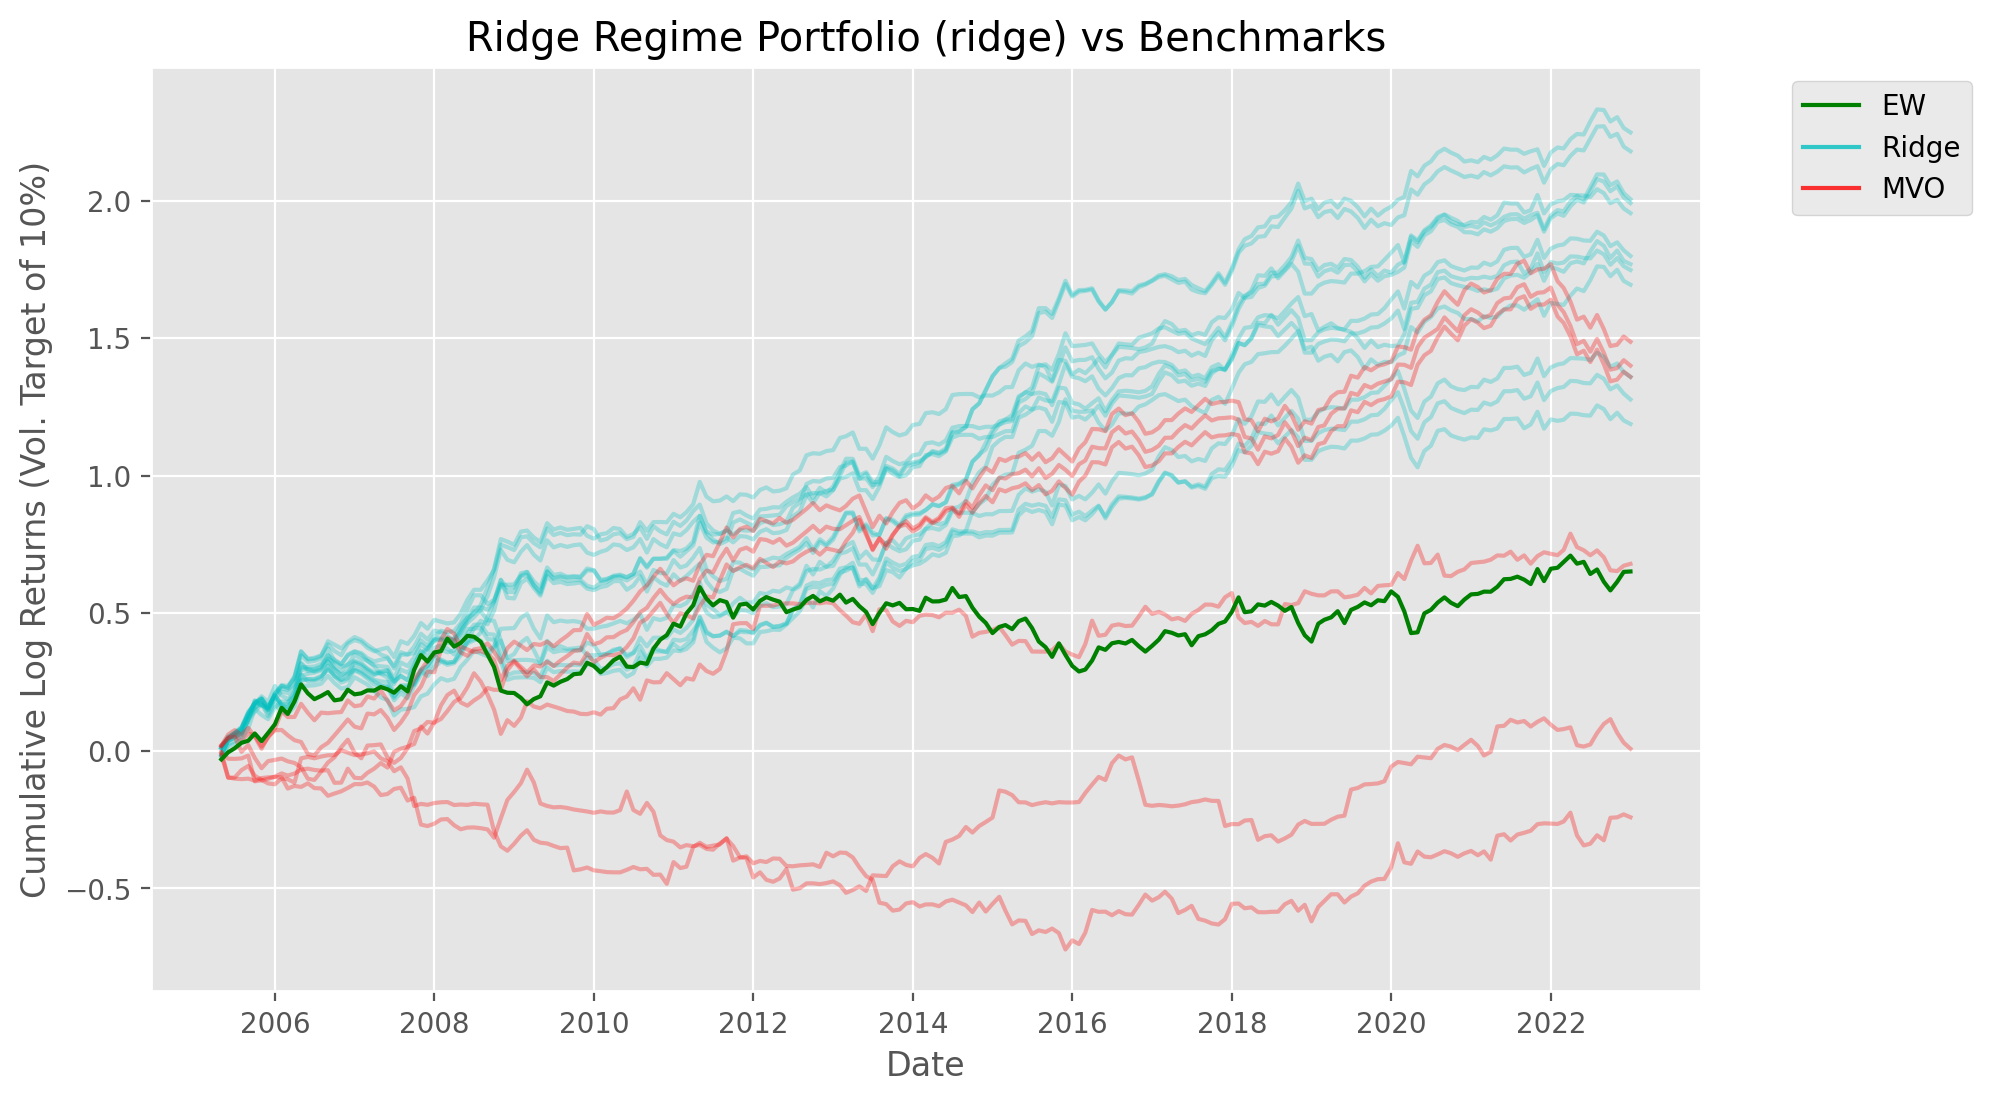

In [25]:
super_benchmarks = ['ew']
selected_model_list = [
    'linear-ridge_lns_2',
    'linear-ridge_mx_2',
    'linear-ridge_los_2',
    'linear-ridge_lo_2',
    'linear-ridge_lns_3',
    'linear-ridge_mx_3',
    'linear-ridge_los_3',
    'linear-ridge_lo_3',
    'linear-ridge_lns_4',
    'linear-ridge_mx_4',
    'linear-ridge_los_4',
    'linear-ridge_lo_4',
   # 'linear-ridge_mx_5',
   #  'linear-ridge_los_5',
   #  'linear-ridge_lo_5',

    'mvo_lns_2',
    'mvo_lo_2',
    'mvo_lns_3',
    'mvo_lo_3',
    'mvo_lns_4',
    'mvo_lo_4',
]

returns = pd.concat(concat_list, axis=1).copy()[selected_model_list + super_benchmarks]
cum_returns_plot = returns.cumsum()

# Volatility scaling
vol_target = 0.10
portfolio_vol = vol_target / (returns.rolling(window=12).std().bfill() * np.sqrt(12))
voladj_returns = (returns * portfolio_vol).dropna()
cum_voladj_returns = voladj_returns.cumsum()
order = cum_voladj_returns.mean(axis=0).sort_values(ascending=False).index

# Group models 
naive_models = [m for m in selected_model_list if m.startswith('linear-ridge')]
mvo_models = [m for m in selected_model_list if m.startswith('mvo')]

# Define colors for each group
colors = {
   'linear-ridge': 'red',
   'mvo': 'blue', 
   'ew': 'green',
   'spy': 'black'
}

fig, ax = plt.subplots(figsize=(10, 6))

# Plot naive models in blue
for model in naive_models:
   plt.plot(cum_voladj_returns.index, cum_voladj_returns[model], color='c', alpha=0.3)

# Plot mvo models in red  
for model in mvo_models:
   plt.plot(cum_voladj_returns.index, cum_voladj_returns[model], color='red', alpha=0.3)

# Plot benchmarks
plt.plot(cum_voladj_returns.index, cum_voladj_returns['ew'], color='green', label='EW')
# plt.plot(cum_voladj_returns.index, cum_voladj_returns['spy'], color='black', label='SPY')

# Add representative lines for legend
plt.plot([], [], color='c', label='Ridge', alpha=0.8)
plt.plot([], [], color='red', label='MVO', alpha=0.8)

plt.title(f"Ridge Regime Portfolio (ridge) vs Benchmarks")
plt.ylabel("Cumulative Log Returns (Vol. Target of 10%)")
plt.xlabel("Date")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)

# save image
plt.savefig(os.path.join(outputs_path, "results", "futures_ridge_vs_benchmarks_cumret.png"), bbox_inches='tight', dpi=300)

plt.show()

In [26]:
selected_summary_statistics = []
for model in cum_voladj_returns.columns:
    if model not in super_benchmarks:
        summary_statistics = pd.DataFrame([all_summary_statistics_df.loc[model]], index=[model])
        selected_summary_statistics.append(summary_statistics)
selected_summary_statistics_df = pd.concat(selected_summary_statistics)

selected_summary_statistics_df.round(3)

E[R]  Std(R)  Sharpe  Sortino  AvgDD   MaxDD  \
linear-ridge_lns_2  5.637  19.106   1.022    2.705 -1.098  -8.656   
linear-ridge_mx_2   3.628  11.946   1.052    1.507 -1.199 -11.528   
linear-ridge_los_2  3.789  14.589   0.900    1.471 -2.009  -9.568   
linear-ridge_lo_2   2.691  12.239   0.762    1.100 -2.132 -11.528   
linear-ridge_lns_3  5.353  14.403   1.287    2.571 -0.955  -6.520   
linear-ridge_mx_3   3.703  11.322   1.133    1.876 -0.692  -5.385   
linear-ridge_los_3  4.856  13.271   1.268    2.216 -1.014  -6.792   
linear-ridge_lo_3   2.744  11.660   0.815    1.321 -1.320  -6.448   
linear-ridge_lns_4  5.187  18.223   0.986    0.945 -2.078 -13.748   
linear-ridge_mx_4   5.040  20.925   0.834    2.535 -0.585  -4.078   
linear-ridge_los_4  5.272  13.621   1.341    2.058 -0.989  -6.379   
linear-ridge_lo_4   3.887  21.144   0.637    1.790 -1.208  -6.645   
mvo_lns_2           0.924  13.877   0.231    0.304 -7.055 -19.428   
mvo_lo_2            3.870  12.865   1.042    2.132 -1.069  -7.844   
mvo_lns_3           0.391  11.448   0.118    0.199 -8.473 -17.689   
mvo_lo_3            5.874  18.653   1.091    3.558 -0.978  -7.721   
mvo_lns_4           2.090  17.326   0.418    0.444 -7.412 -17.344   
mvo_lo_4            5.540  17.569   1.092    3.383 -1.079  -7.633   

                    % Positive Ret.  
linear-ridge_lns_2            0.635  
linear-ridge_mx_2             0.626  
linear-ridge_los_2            0.621  
linear-ridge_lo_2             0.583  
linear-ridge_lns_3            0.645  
linear-ridge_mx_3             0.597  
linear-ridge_los_3            0.640  
linear-ridge_lo_3             0.559  
linear-ridge_lns_4            0.654  
linear-ridge_mx_4             0.597  
linear-ridge_los_4            0.640  
linear-ridge_lo_4             0.564  
mvo_lns_2                     0.536  
mvo_lo_2                      0.616  
mvo_lns_3                     0.521  
mvo_lo_3                      0.607  
mvo_lns_4                     0.555  
mvo_lo_4                      0.611

In [83]:
print(selected_summary_statistics_df.drop(['E[R]', 'Std(R)', 'AvgDD'], axis=1).round(3).to_latex())

\begin{tabular}{lrrrr}
\toprule
 & Sharpe & Sortino & MaxDD & % Positive Ret. \\
\midrule
linear-ridge_lns_2 & 1.022000 & 2.705000 & -8.656000 & 0.635000 \\
linear-ridge_mx_2 & 1.052000 & 1.507000 & -11.528000 & 0.626000 \\
linear-ridge_los_2 & 0.900000 & 1.471000 & -9.568000 & 0.621000 \\
linear-ridge_lo_2 & 0.762000 & 1.100000 & -11.528000 & 0.583000 \\
linear-ridge_lns_3 & 1.287000 & 2.571000 & -6.520000 & 0.645000 \\
linear-ridge_mx_3 & 1.133000 & 1.876000 & -5.385000 & 0.597000 \\
linear-ridge_los_3 & 1.268000 & 2.216000 & -6.792000 & 0.640000 \\
linear-ridge_lo_3 & 0.815000 & 1.321000 & -6.448000 & 0.559000 \\
linear-ridge_lns_4 & 0.986000 & 0.945000 & -13.748000 & 0.654000 \\
linear-ridge_mx_4 & 0.834000 & 2.535000 & -4.078000 & 0.597000 \\
linear-ridge_los_4 & 1.341000 & 2.058000 & -6.379000 & 0.640000 \\
linear-ridge_lo_4 & 0.637000 & 1.790000 & -6.645000 & 0.564000 \\
mvo_lns_2 & 0.240000 & 0.413000 & -18.311000 & 0.507000 \\
mvo_lo_2 & 1.050000 & 2.589000 & -7.998000 & 0.607

## Nemenyi Test ($H_0: \text{Average Treatment Rank} = \text{Average Control Rank}$)

In [27]:
def nemenyi_test(metric_values, control, treatment, alpha=0.05):
   # Prepare data matrix where rows are samples and columns are methods
   data = np.array([metric_values[control], metric_values[treatment]]).T
   
   # Calculate ranks for each row
   ranks = np.array([stats.rankdata(row) for row in data])
   mean_ranks = np.mean(ranks, axis=0)
   
   # Calculate critical distance
   k = 2  # number of methods being compared
   n = len(control)  # number of samples
   q = stats.studentized_range.ppf(1 - alpha, k, np.inf) / np.sqrt(2)
   cd = q * np.sqrt((k * (k + 1)) / (6 * n))
   
   return mean_ranks, cd

In [28]:
metric_names = ["Sharpe", "Sortino", "MaxDD", "% Positive Ret."]
control = ["naive_lns_2_rand", "naive_lo_2_rand", "naive_lns_3_rand", "naive_lo_3_rand", "naive_lns_4_rand", "naive_lo_4_rand"]
treatment = ["naive_lns_2", "naive_lo_2", "naive_lns_3", "naive_lo_3", "naive_lns_4", "naive_lo_4"]

results = []
for metric_name in metric_names:
   metric_values = all_summary_statistics_df.loc[control+treatment][metric_name]
   mean_ranks, cd = nemenyi_test(metric_values, control, treatment)
   
   # T-test
   group1 = metric_values[control]
   group2 = metric_values[treatment]
   t_stat, p_value = stats.ttest_rel(group2, group1, alternative='greater')
   
   results.append({
       'Metric': metric_name,
       'Control Rank': mean_ranks[0],
       'Treatment Rank': mean_ranks[1],
    #    'Critical Distance': cd,
       'p-value': p_value
   })

results_df = pd.DataFrame(results)
print("Naive")
print(results_df.to_string(float_format=lambda x: '{:.3f}'.format(x)))

Naive
            Metric  Control Rank  Treatment Rank  p-value
0           Sharpe         1.000           2.000    0.002
1          Sortino         1.167           1.833    0.094
2            MaxDD         1.333           1.667    0.032
3  % Positive Ret.         1.167           1.833    0.012


In [29]:
metric_names = ["Sharpe", "Sortino", "MaxDD", "% Positive Ret."]
control = ["bl_lns_2_rand", "bl_lo_2_rand", "bl_lns_3_rand", "bl_lo_3_rand", "bl_lns_4_rand", "bl_lo_4_rand"]
treatment = ["bl_lns_2", "bl_lo_2", "bl_lns_3", "bl_lo_3", "bl_lns_4", "bl_lo_4"]

results = []
for metric_name in metric_names:
   metric_values = all_summary_statistics_df.loc[control+treatment][metric_name]
   mean_ranks, cd = nemenyi_test(metric_values, control, treatment)
   
   # T-test
   group1 = metric_values[control]
   group2 = metric_values[treatment]
   t_stat, p_value = stats.ttest_rel(group2, group1, alternative='greater')
   
   results.append({
       'Metric': metric_name,
       'Control Rank': mean_ranks[0],
       'Treatment Rank': mean_ranks[1],
    #    'Critical Distance': cd,
       'p-value': p_value
   })

results_df = pd.DataFrame(results)
print("Black-Litterman")
print(results_df.to_string(float_format=lambda x: '{:.3f}'.format(x)))

Black-Litterman
            Metric  Control Rank  Treatment Rank  p-value
0           Sharpe         1.667           1.333    0.578
1          Sortino         1.667           1.333    0.628
2            MaxDD         1.333           1.667    0.703
3  % Positive Ret.         1.833           1.167    0.984


In [30]:
metric_names = ["Sharpe", "Sortino", "MaxDD", "% Positive Ret."]
control = [
    "linear-ridge_lo_2_rand", "linear-ridge_lo_3_rand", "linear-ridge_lo_4_rand", 
    "linear-ridge_lns_3_rand", "linear-ridge_lns_2_rand",  "linear-ridge_lns_4_rand", 
    "linear-ridge_los_3_rand", "linear-ridge_los_2_rand",  "linear-ridge_los_4_rand", 
    "linear-ridge_mx_3_rand", "linear-ridge_mx_2_rand",  "linear-ridge_mx_4_rand", 
]
treatment = [
    "linear-ridge_lo_2", "linear-ridge_lo_3", "linear-ridge_lo_4", 
    "linear-ridge_lns_3", "linear-ridge_lns_2",  "linear-ridge_lns_4", 
    "linear-ridge_los_3", "linear-ridge_los_2",  "linear-ridge_los_4", 
    "linear-ridge_mx_3", "linear-ridge_mx_2",  "linear-ridge_mx_4", 
]

results = []
for metric_name in metric_names:
   metric_values = all_summary_statistics_df.loc[control+treatment][metric_name]
   mean_ranks, cd = nemenyi_test(metric_values, control, treatment)
   
   # T-test
   group1 = metric_values[control]
   group2 = metric_values[treatment]
   t_stat, p_value = stats.ttest_rel(group2, group1, alternative='greater')
   
   results.append({
       'Metric': metric_name,
       'Control Rank': mean_ranks[0],
       'Treatment Rank': mean_ranks[1],
    #    'Critical Distance': cd,
       'p-value': p_value
   })

results_df = pd.DataFrame(results)
print("Ridge")
print(results_df.to_string(float_format=lambda x: '{:.3f}'.format(x)))

Ridge
            Metric  Control Rank  Treatment Rank  p-value
0           Sharpe         1.000           2.000    0.000
1          Sortino         1.000           2.000    0.000
2            MaxDD         1.083           1.917    0.002
3  % Positive Ret.         1.000           2.000    0.000


## T-test for Two Related Samples ($H_0: \mu_c > \mu_t$)

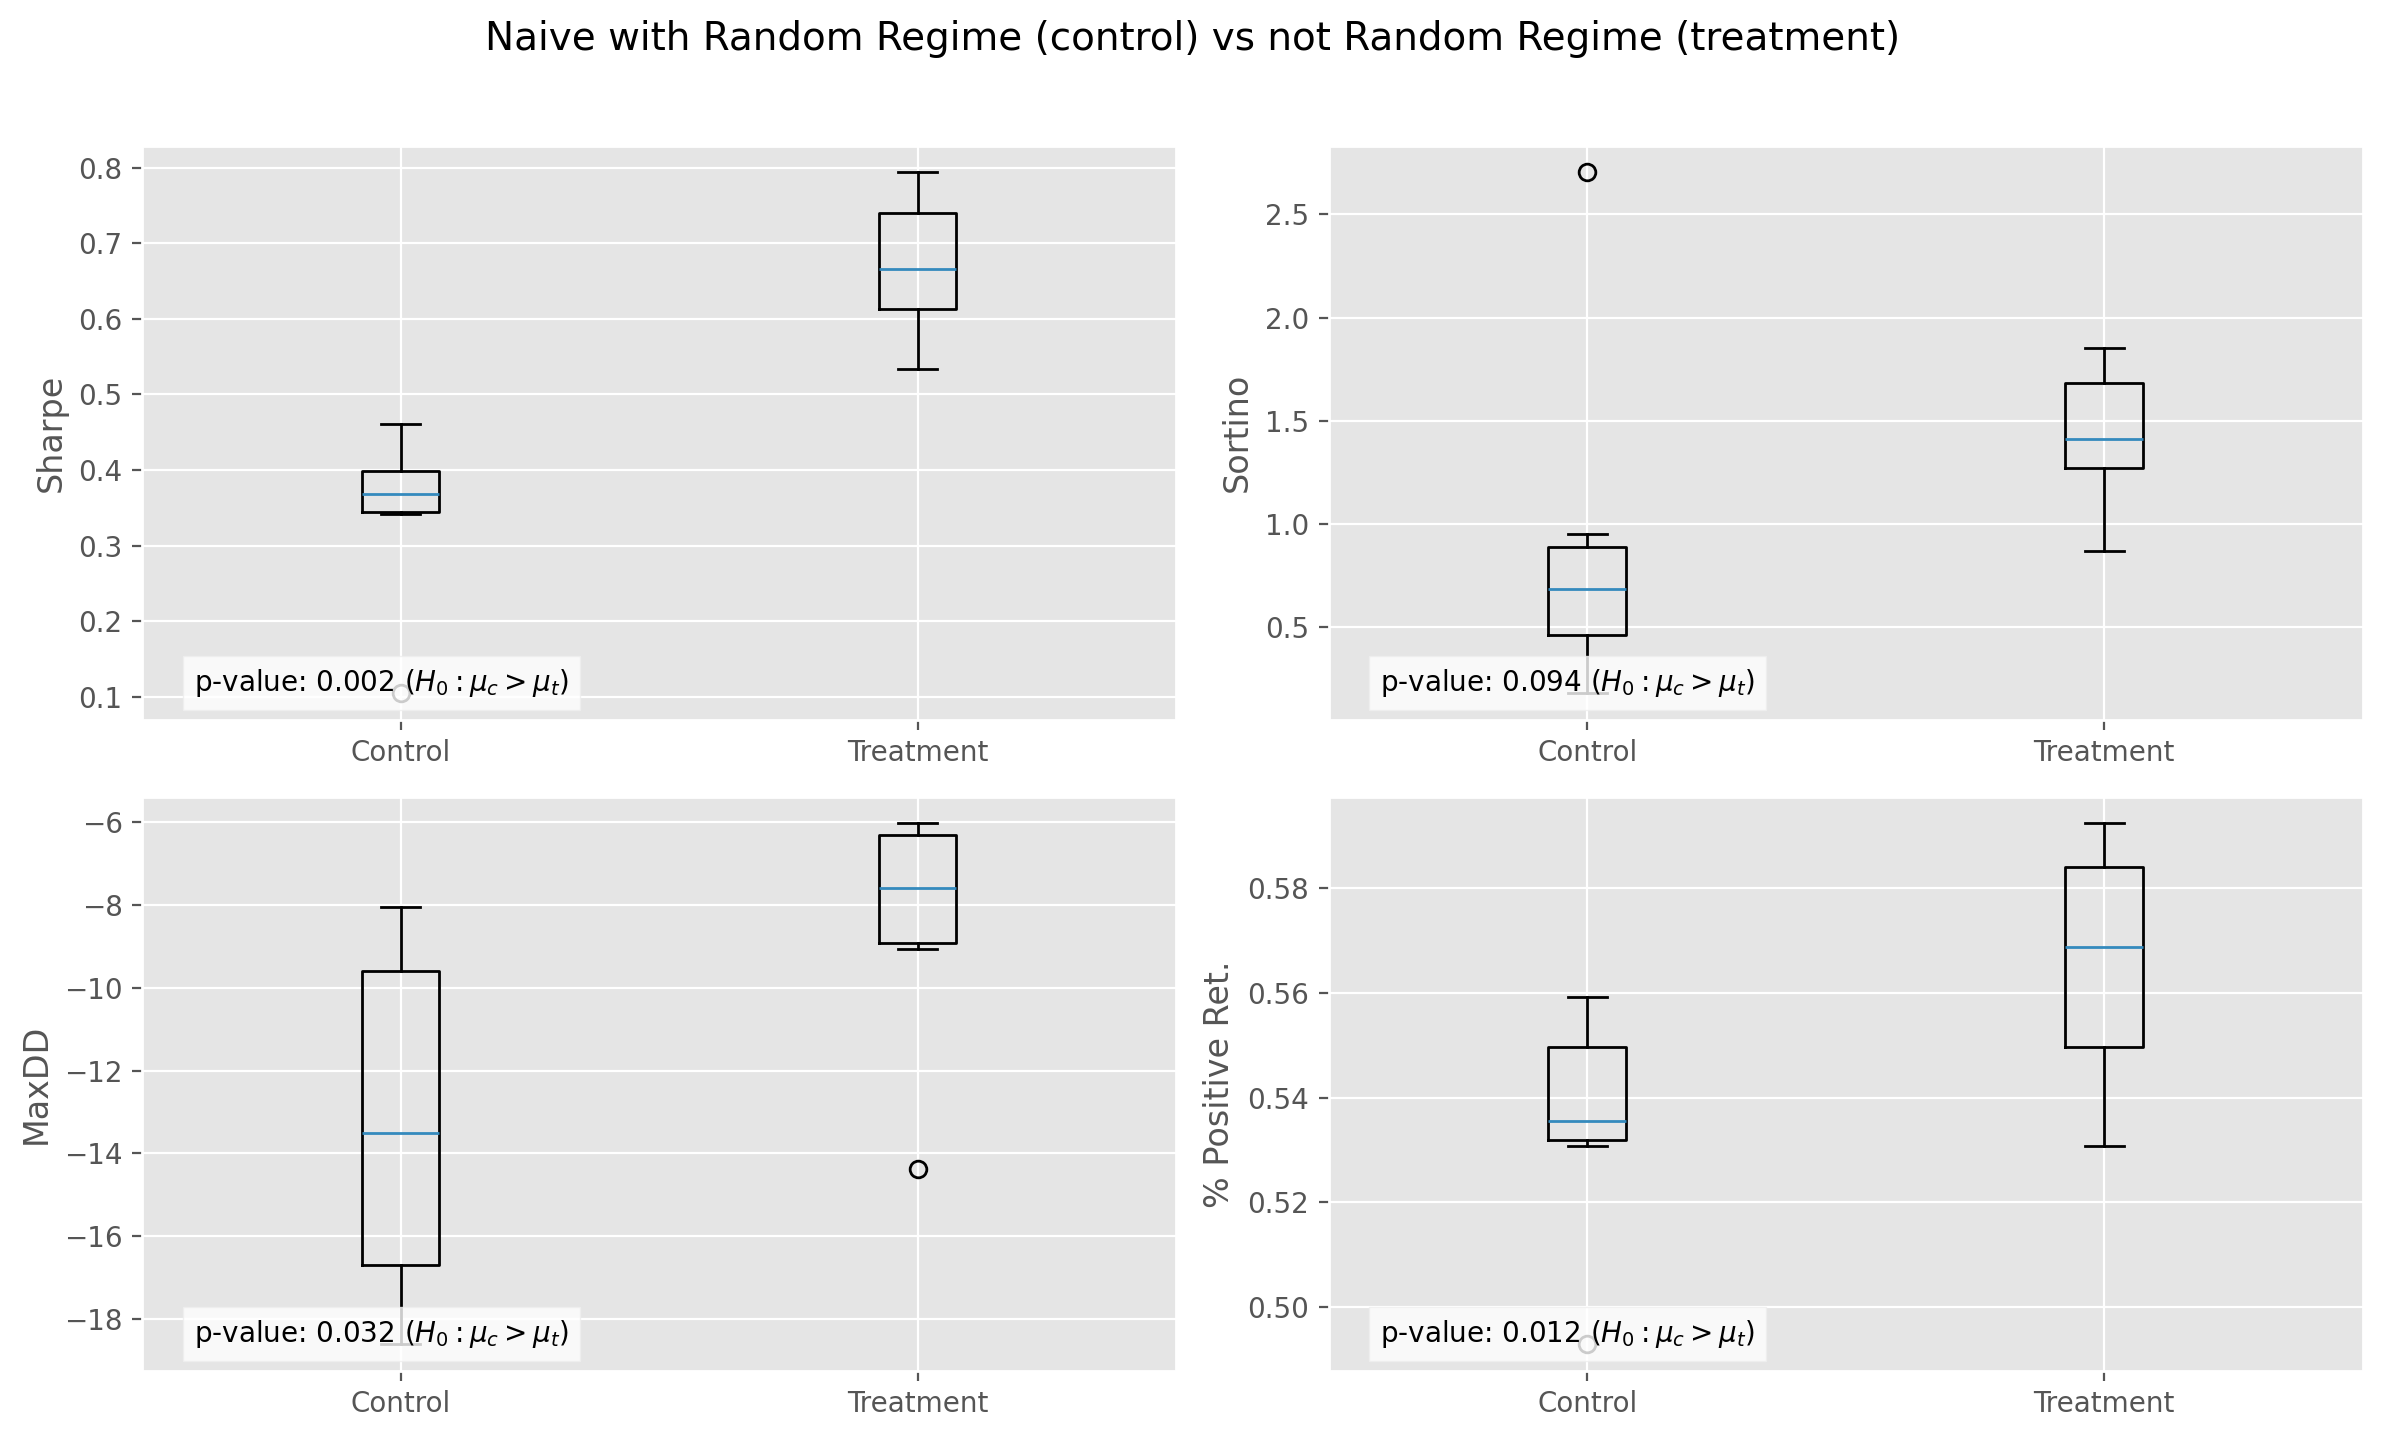

In [31]:
metric_names = ["Sharpe", "Sortino", "MaxDD", "% Positive Ret."]
control = ["naive_lns_2_rand", "naive_lo_2_rand", "naive_lns_3_rand", "naive_lo_3_rand", "naive_lns_4_rand", "naive_lo_4_rand"]
treatment = ["naive_lns_2", "naive_lo_2", "naive_lns_3", "naive_lo_3", "naive_lns_4", "naive_lo_4"]

fig, axes = plt.subplots(2, 2, figsize=(12, 7))
axes = axes.ravel()

fig.suptitle('Naive with Random Regime (control) vs not Random Regime (treatment)', fontsize=14, y=1.02)
for i, metric_name in enumerate(metric_names):
   metric_values = all_summary_statistics_df.loc[control+treatment][metric_name]
   data = [metric_values[control], metric_values[treatment]]
   
   axes[i].boxplot(data, labels=['Control', 'Treatment'])
   # axes[i].set_title(metric_name)
   axes[i].set_ylabel(metric_name)
   axes[i].grid(True)

   group1 = metric_values[control]
   group2 = metric_values[treatment]
   t_stat, p_value = stats.ttest_rel(group2, group1, alternative='greater')
   
   axes[i].text(0.05, 0.05, f'p-value: {p_value:.3f} ($H_0: \mu_c > \mu_t$)', 
               transform=axes[i].transAxes,
               bbox=dict(facecolor='white', alpha=0.8))

plt.tight_layout()

# save image
plt.savefig(os.path.join(outputs_path, "results", "futures_naive_boxplots_metrics.png"), bbox_inches='tight', dpi=300)

plt.show()

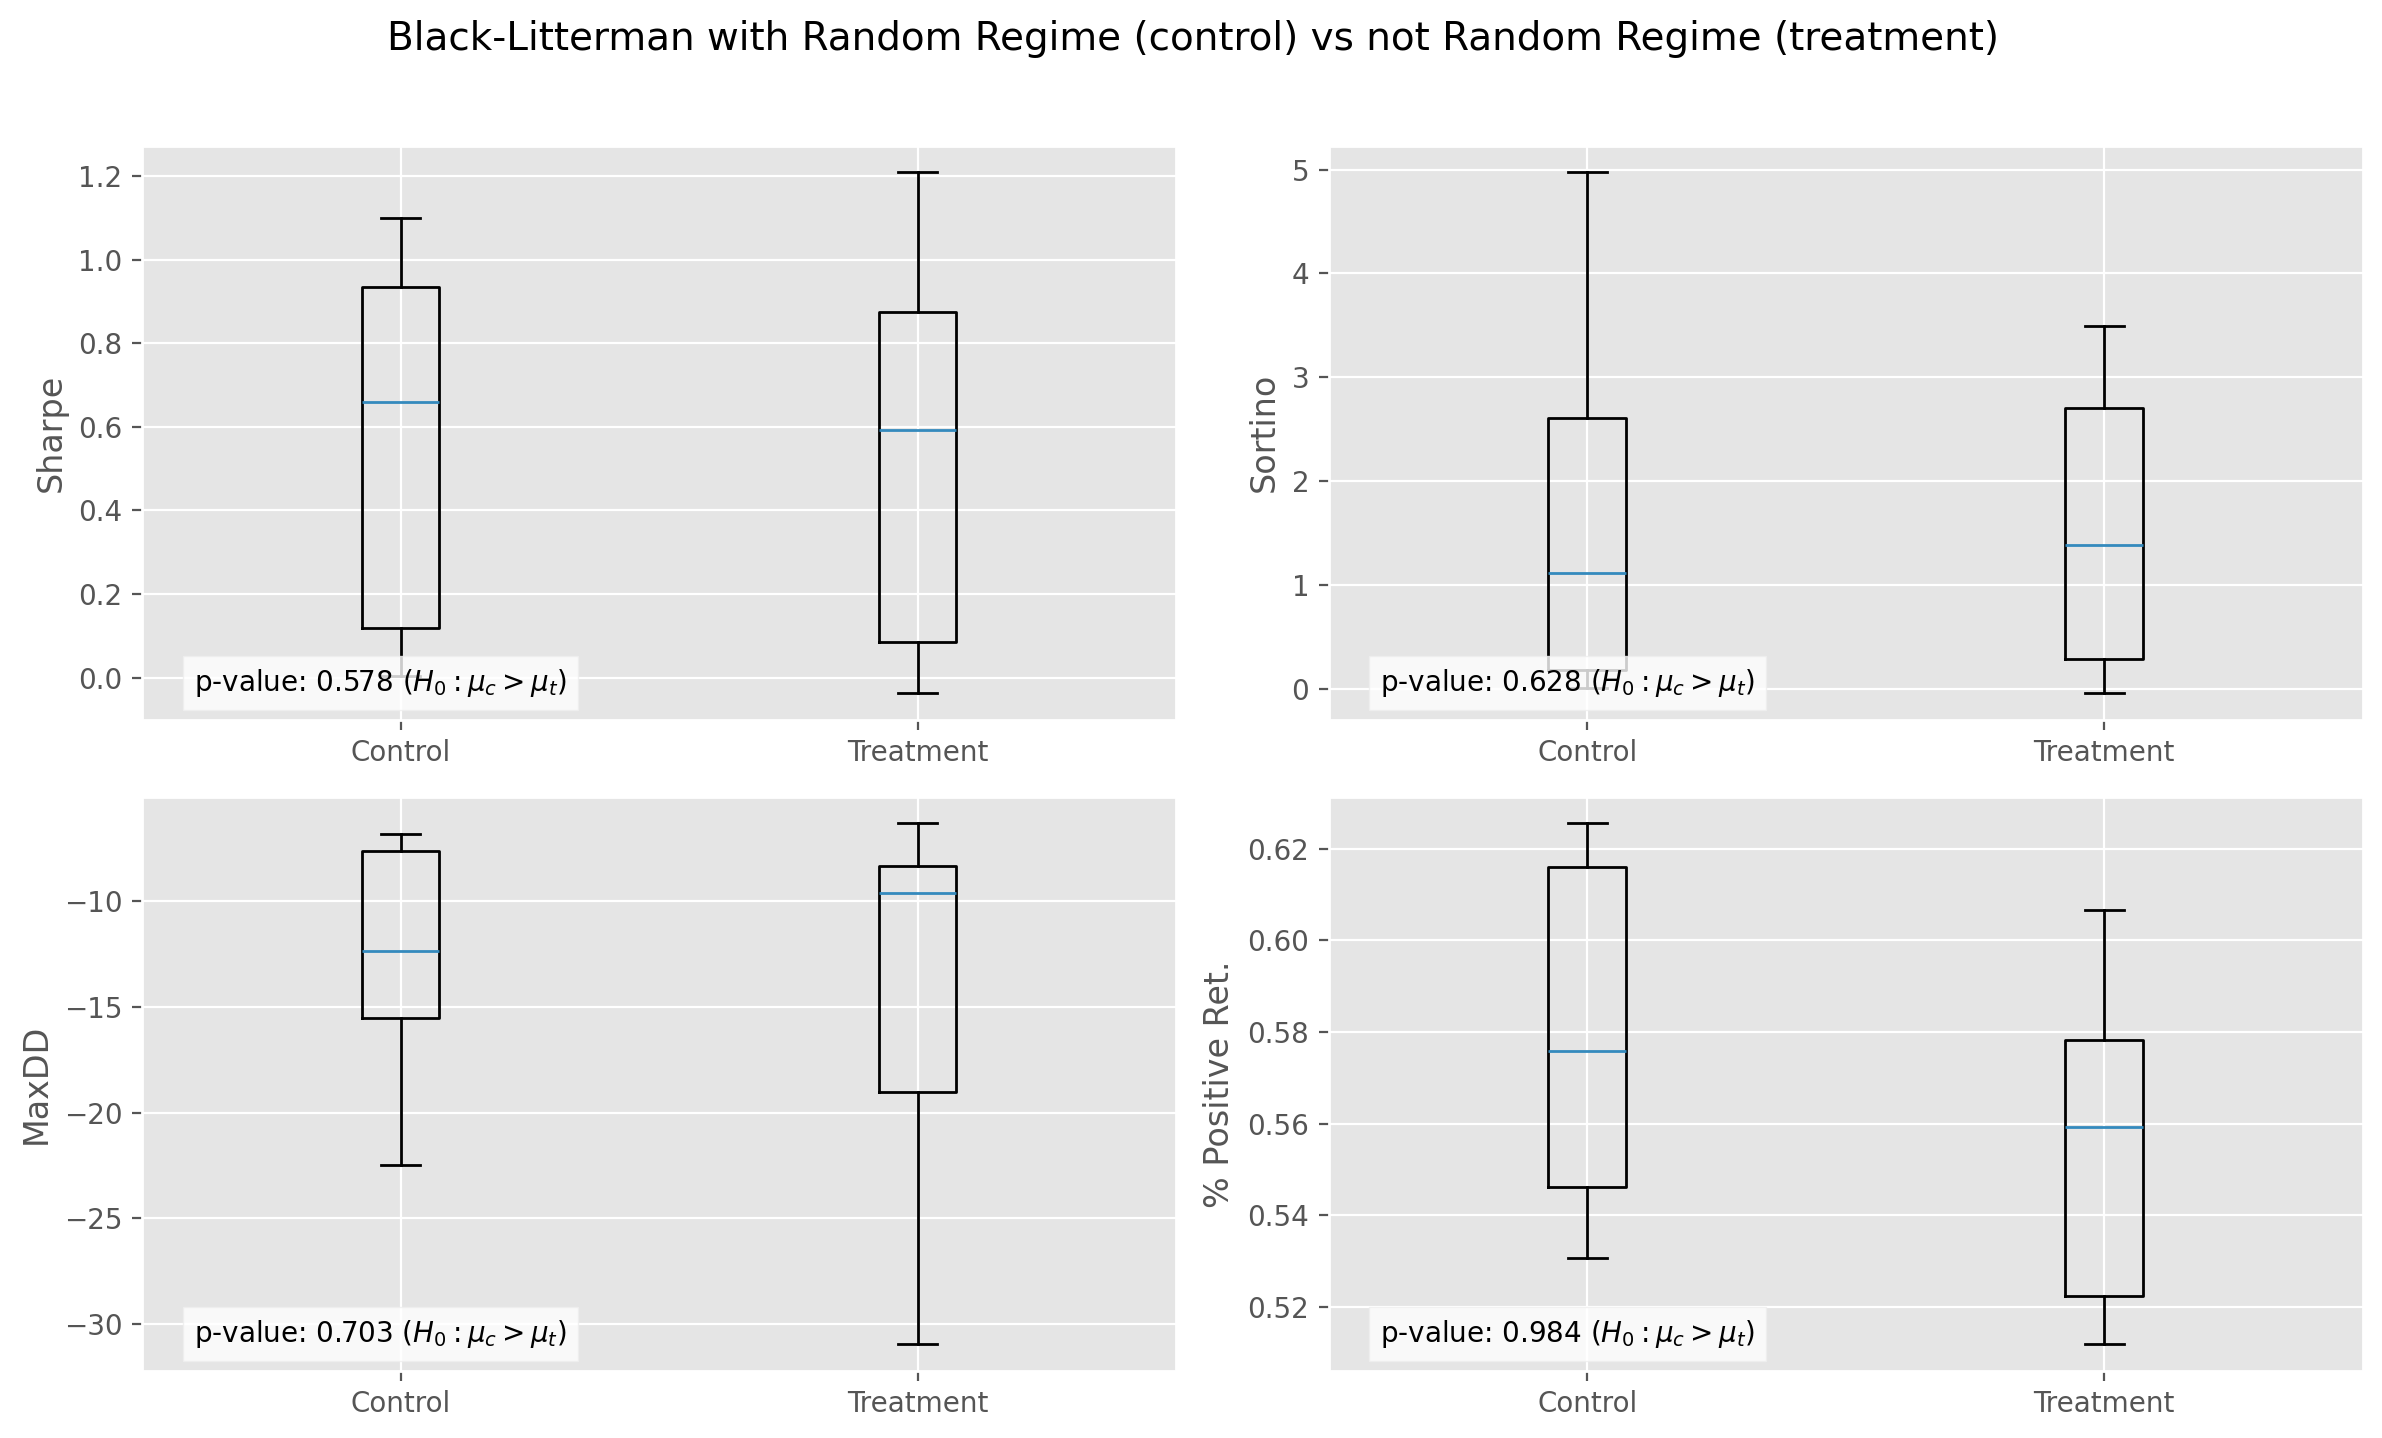

In [36]:
metric_names = ["Sharpe", "Sortino", "MaxDD", "% Positive Ret."]
# control = ["mvo_lns_2", "mvo_lo_2", "mvo_lns_3", "mvo_lo_3", "mvo_lns_4", "mvo_lo_4"]
control = ["bl_lns_2_rand", "bl_lo_2_rand", "bl_lns_3_rand", "bl_lo_3_rand", "bl_lns_4_rand", "bl_lo_4_rand"]
treatment = ["bl_lns_2", "bl_lo_2", "bl_lns_3", "bl_lo_3", "bl_lns_4", "bl_lo_4"]

fig, axes = plt.subplots(2, 2, figsize=(12, 7))
axes = axes.ravel()

fig.suptitle('Black-Litterman with Random Regime (control) vs not Random Regime (treatment)', fontsize=14, y=1.02)
for i, metric_name in enumerate(metric_names):
   metric_values = all_summary_statistics_df.loc[control+treatment][metric_name]
   data = [metric_values[control], metric_values[treatment]]
   
   axes[i].boxplot(data, labels=['Control', 'Treatment'])
   # axes[i].set_title(metric_name)
   axes[i].set_ylabel(metric_name)
   axes[i].grid(True)

   group1 = metric_values[control]
   group2 = metric_values[treatment]
   t_stat, p_value = stats.ttest_rel(group2, group1, alternative='greater')
   
   axes[i].text(0.05, 0.05, f'p-value: {p_value:.3f} ($H_0: \mu_c > \mu_t$)', 
               transform=axes[i].transAxes,
               bbox=dict(facecolor='white', alpha=0.8))

plt.tight_layout()

# save image
plt.savefig(os.path.join(outputs_path, "results", "futures_mvo_boxplots_metrics.png"), bbox_inches='tight', dpi=300)

plt.show()

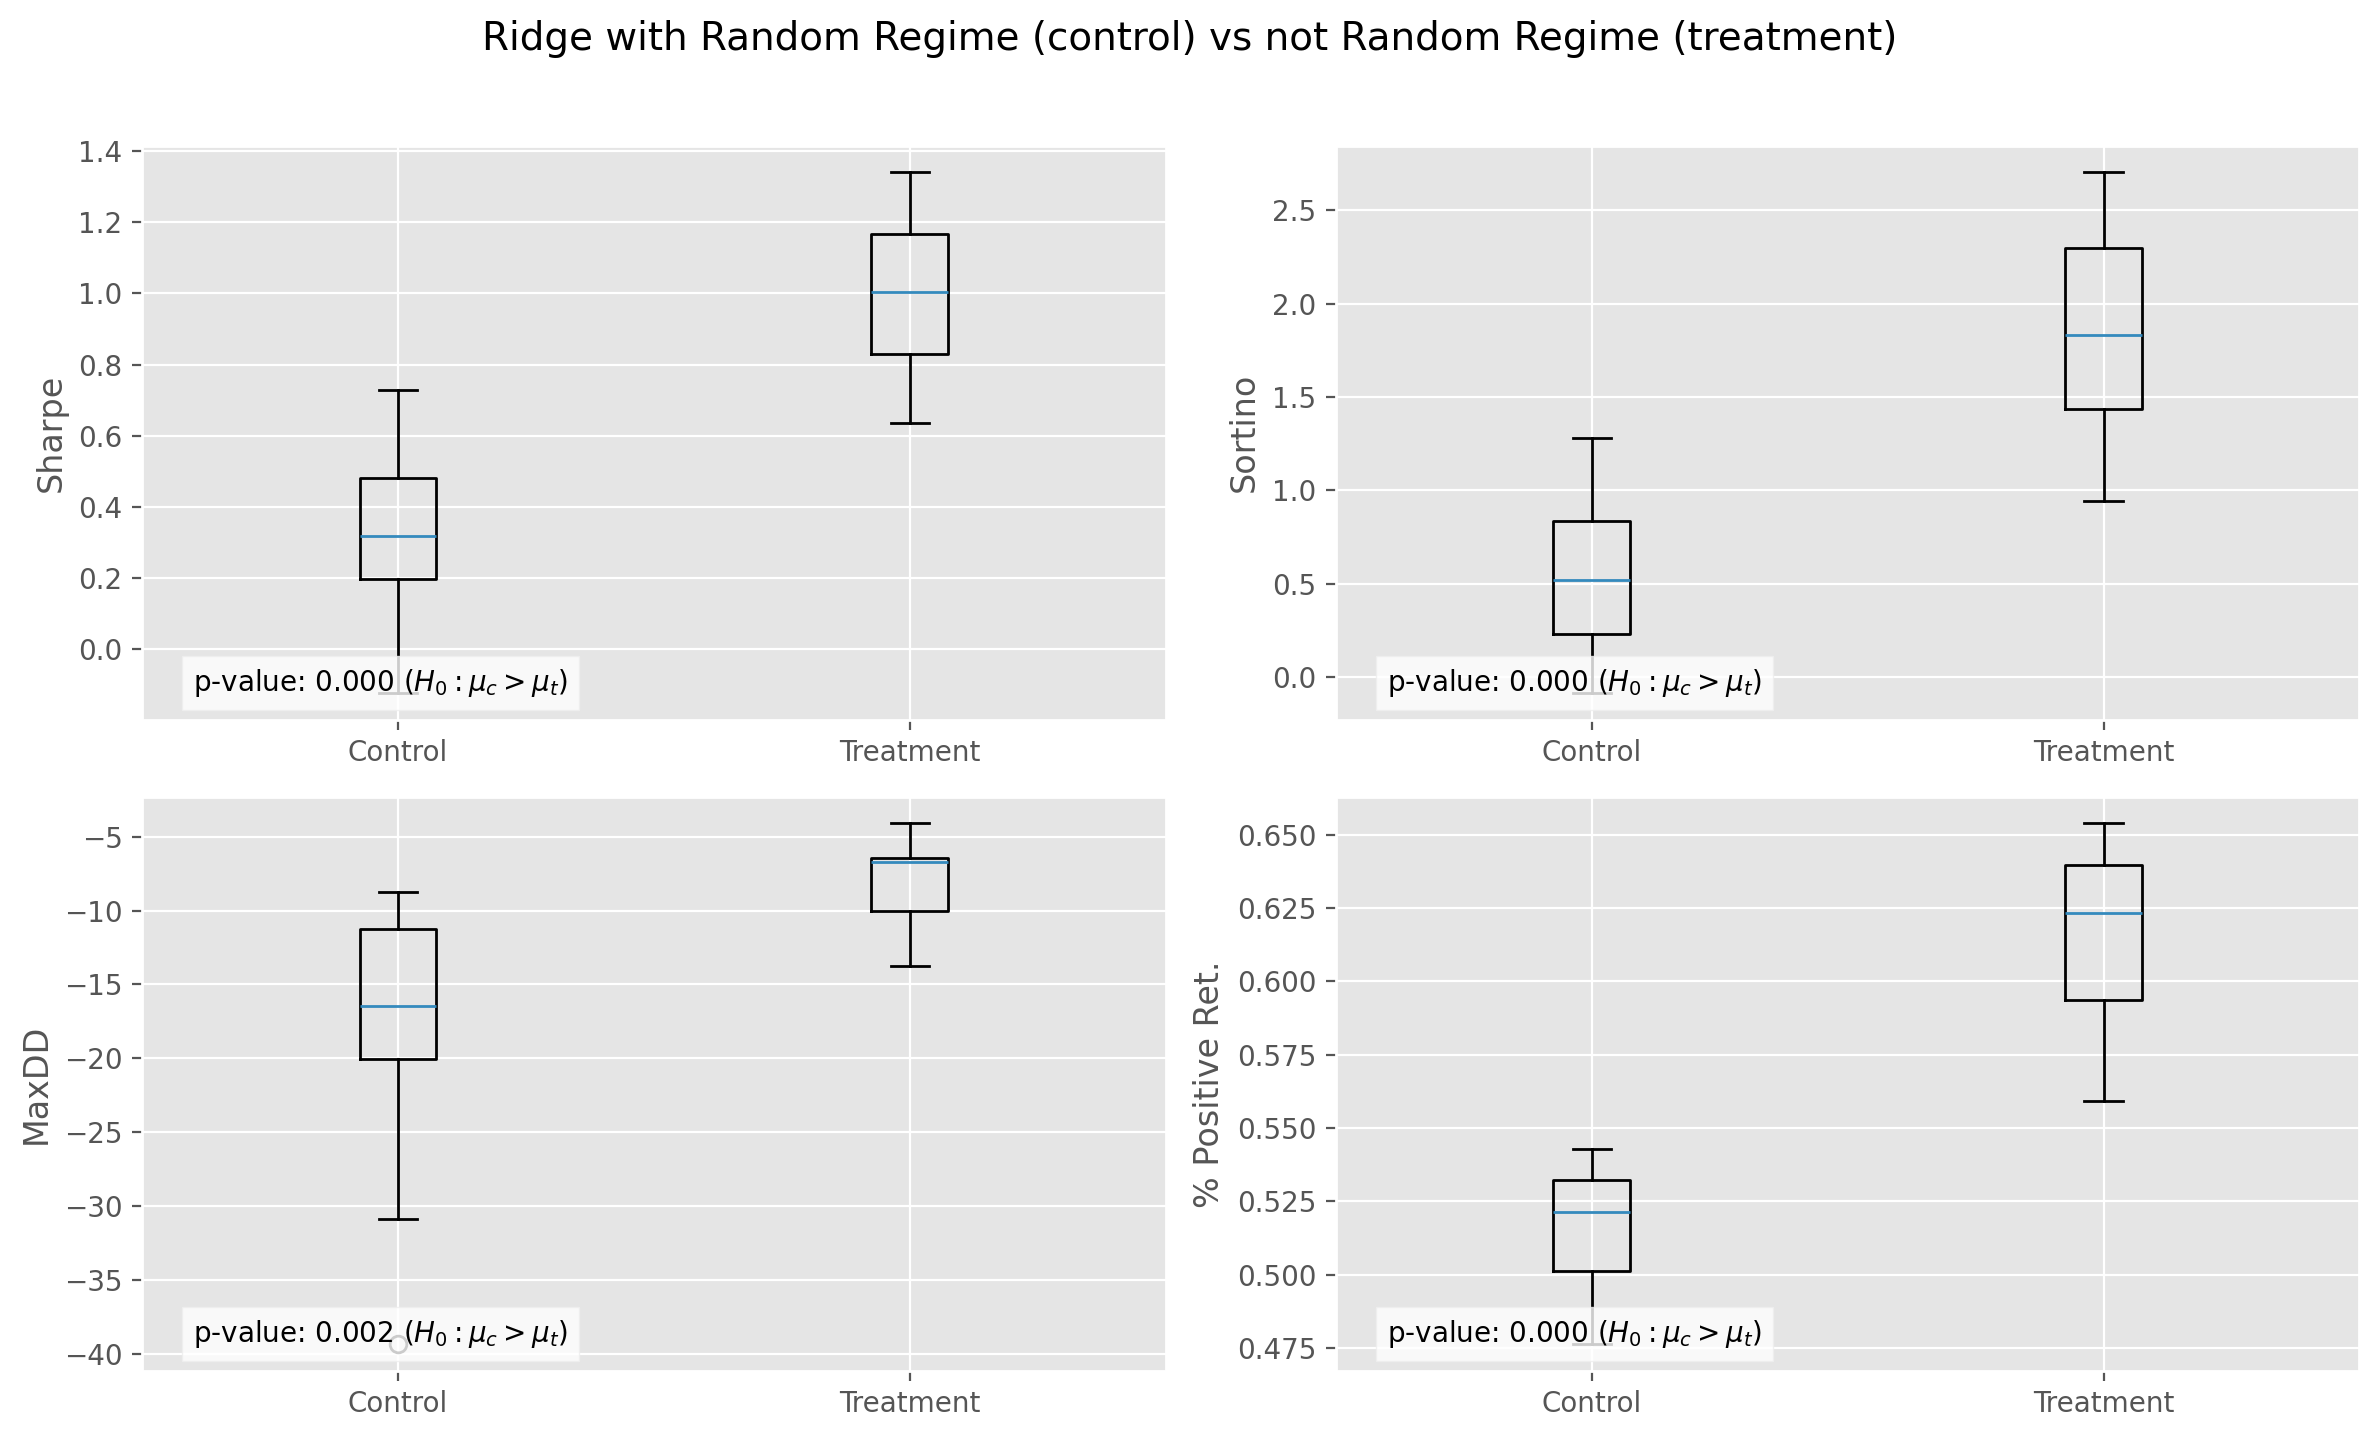

In [33]:
metric_names = ["Sharpe", "Sortino", "MaxDD", "% Positive Ret."]
control = [
    "linear-ridge_lo_2_rand", "linear-ridge_lo_3_rand", "linear-ridge_lo_4_rand", 
    "linear-ridge_lns_3_rand", "linear-ridge_lns_2_rand",  "linear-ridge_lns_4_rand", 
    "linear-ridge_los_3_rand", "linear-ridge_los_2_rand",  "linear-ridge_los_4_rand", 
    "linear-ridge_mx_3_rand", "linear-ridge_mx_2_rand",  "linear-ridge_mx_4_rand", 
]
treatment = [
    "linear-ridge_lo_2", "linear-ridge_lo_3", "linear-ridge_lo_4", 
    "linear-ridge_lns_3", "linear-ridge_lns_2",  "linear-ridge_lns_4", 
    "linear-ridge_los_3", "linear-ridge_los_2",  "linear-ridge_los_4", 
    "linear-ridge_mx_3", "linear-ridge_mx_2",  "linear-ridge_mx_4", 
]

fig, axes = plt.subplots(2, 2, figsize=(12, 7))
axes = axes.ravel()

fig.suptitle('Ridge with Random Regime (control) vs not Random Regime (treatment)', fontsize=14, y=1.02)
for i, metric_name in enumerate(metric_names):
   metric_values = all_summary_statistics_df.loc[control+treatment][metric_name]
   data = [metric_values[control], metric_values[treatment]]
   
   axes[i].boxplot(data, labels=['Control', 'Treatment'])
   # axes[i].set_title(metric_name)
   axes[i].set_ylabel(metric_name)
   axes[i].grid(True)

   group1 = metric_values[control]
   group2 = metric_values[treatment]
   t_stat, p_value = stats.ttest_rel(group2, group1, alternative='greater')
   
   axes[i].text(0.05, 0.05, f'p-value: {p_value:.3f} ($H_0: \mu_c > \mu_t$)', 
               transform=axes[i].transAxes,
               bbox=dict(facecolor='white', alpha=0.8))

plt.tight_layout()

# save image
plt.savefig(os.path.join(outputs_path, "results", "futures_ridge_boxplots_metrics.png"), bbox_inches='tight', dpi=300)

plt.show()